# Project 5

## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

## Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


## Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

Plan: 
1 - Data preparation
2 - Exploratory Data Analysis 
3 - Feature engineering
4 - Model selection
5 - Decision making
<!-- Data Preparation:

Combine all the different sheets into a single dataset.
Check for any missing or null values and handle them appropriately.
Convert the date column to a datetime format for easy manipulation.
Extract the day, week, and month from the date column for daily, weekly, and monthly predictions.

Exploratory Data Analysis (EDA):

Conduct a comprehensive EDA to identify patterns, trends, and outliers in the data.
Use visualizations such as line plots, scatter plots, histograms, and box plots to explore the data.
Calculate basic statistics such as mean, median, standard deviation, and correlation to gain insights into the data.

Feature Engineering:

Create new features such as moving averages, exponential moving averages, and Bollinger Bands to help capture trends and patterns in the data.
Use technical indicators such as Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Stochastic Oscillator to create additional features.

Model Selection:

Select appropriate models such as Linear Regression, Random Forest Regression, and Support Vector Regression (SVR) to predict the stock prices.
Train the models using the 2020 data and test them on the 2021 Q1 data.
Use evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared to evaluate the performance of the models.

Decision Making:

Use the predicted stock prices to make BUY, HOLD, or SELL decisions.
Calculate the capital returns based on the decisions made.
Use Bollinger Bands to measure the effectiveness of the system.
Minimize the HOLD period by adjusting the decision-making criteria based on the performance of the system -->

In [1]:
#!pip install statsmodels --upgrade
#!pip install TA-Lib
#!pip install fbprophet
#!pip install pmdarima

In [2]:
# linear algebra
import numpy as np 
import random
import math

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

import re
from pylab import rcParams
import statsmodels.api as sm

import talib as ta

import itertools

# Algorithms

from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from pmdarima import auto_arima

Importing plotly failed. Interactive plots will not work.


# 1 - Data preparation

In [3]:
def clean_sheets(og_data, num):
    def remove_letters(val):
        if isinstance(val, str):
            num = re.findall(r"\d+\.?\d*", val)
            if len(num) > 0:
                num = float(num[0])
                if "K" in val:
                    num /= 1000
                elif "M" in val:
                    num *= 1
                return num
        return val
    data = og_data.parse(num)
    # remove the last row as it contains text
    data.drop([data.shape[0]-1], axis=0, inplace=True)
    #clean up date column
    data[["Date"]] = data[["Date"]].apply(pd.to_datetime)
    #clean up Vol column
    data['Vol.'] = data['Vol.'].apply(remove_letters)
    #make columns numeric
    data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]] = data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]].apply(pd.to_numeric)
    # Set the 'Date' column as the index
    data.set_index('Date', inplace=True)
    # make the Date values the index
    data = data.sort_values(by=['Date'], ascending=True)
    print(data.head())
        # Check data types of columns
    print(data.dtypes)

    # Check for missing values
    print(data.isnull().sum())
    return data

In [4]:
og_data = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [5]:
data0 = clean_sheets(og_data, 0)
data1 = clean_sheets(og_data, 1)
data2 = clean_sheets(og_data, 2)

             Price    Open    High     Low   Vol.  Change %
Date                                                       
2020-01-03  255.00  255.99  258.19  253.70  35.85    0.0010
2020-01-06  253.90  254.75  254.84  251.40  22.35   -0.0043
2020-01-08  259.15  253.57  259.15  253.03  40.82    0.0207
2020-01-09  257.99  259.40  261.76  257.01  38.33   -0.0045
2020-01-10  258.19  257.86  259.25  256.88  18.85    0.0008
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
            Price   Open   High    Low  Vol.  Change %
Date                                                  
2020-01-02  20.38  20.42  20.44  20.24  2.53    0.0030
2020-01-03  20.30  20.30  20.44  19.97  3.31   -0.0039
2020-01-06  20.08  20.34  20.34  19.97  1.94   -0.0108
2020-01-07  19.93  20.22  20.28  19.92  2.89   -0.0075
2020-01-08  19.94  

In [201]:
data = data2

In [202]:
data['Price']

Date
2020-01-02    4.81
2020-01-05    4.41
2020-01-06    4.28
2020-01-08    4.41
2020-01-09    4.62
              ... 
2021-03-25    3.71
2021-03-28    3.71
2021-03-29    3.70
2021-03-30    3.73
2021-03-31    3.75
Name: Price, Length: 305, dtype: float64

In [203]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-02,4.81,4.81,4.87,4.78,0.2416,-0.0021
2020-01-05,4.41,4.70,4.70,4.33,3.7600,-0.0832
2020-01-06,4.28,4.16,4.44,4.12,2.5200,-0.0295
2020-01-08,4.41,4.19,4.59,4.15,3.5200,0.0304
2020-01-09,4.62,4.55,4.70,4.55,2.0900,0.0476


In [204]:
data.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-25,3.71,3.62,3.78,3.59,2.50,0.0137
2021-03-28,3.71,3.76,3.76,3.68,2.34,0.0000
2021-03-29,3.70,3.69,3.73,3.68,1.25,-0.0027
2021-03-30,3.73,3.71,3.76,3.67,3.43,0.0081
2021-03-31,3.75,3.74,3.82,3.71,1.57,0.0054


# 2 - Exploratory Data Analysis 

In [205]:
def exploration(df):
    
    # Summary statistics of the data
    print(df.describe())
        # Visualize data distribution of numeric columns
    df.hist(bins=10, figsize=(15, 10))
    plt.show()

    # Visualize correlation between variables
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()

    # Explore relationships between variables using scatter plots
    sns.pairplot(df, x_vars=['Price', 'Vol.'], y_vars=['Change %'], size=5, aspect=0.8, kind='scatter')
    plt.show()

            Price        Open        High         Low        Vol.    Change %
count  305.000000  305.000000  305.000000  305.000000  305.000000  305.000000
mean     3.554033    3.563475    3.621443    3.490328    6.644313   -0.000522
std      0.621462    0.625575    0.627040    0.619957    6.513951    0.024522
min      2.470000    2.430000    2.510000    2.400000    0.241600   -0.086500
25%      3.030000    3.010000    3.080000    2.960000    2.530000   -0.013700
50%      3.700000    3.700000    3.760000    3.610000    4.870000    0.000000
75%      3.920000    3.940000    3.990000    3.850000    8.830000    0.013000
max      4.890000    4.880000    4.920000    4.830000   55.520000    0.090400


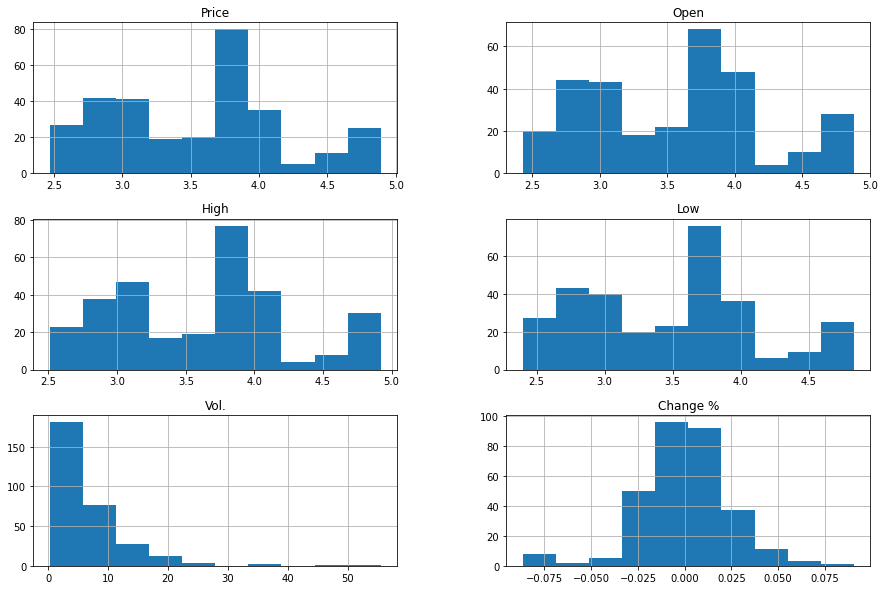

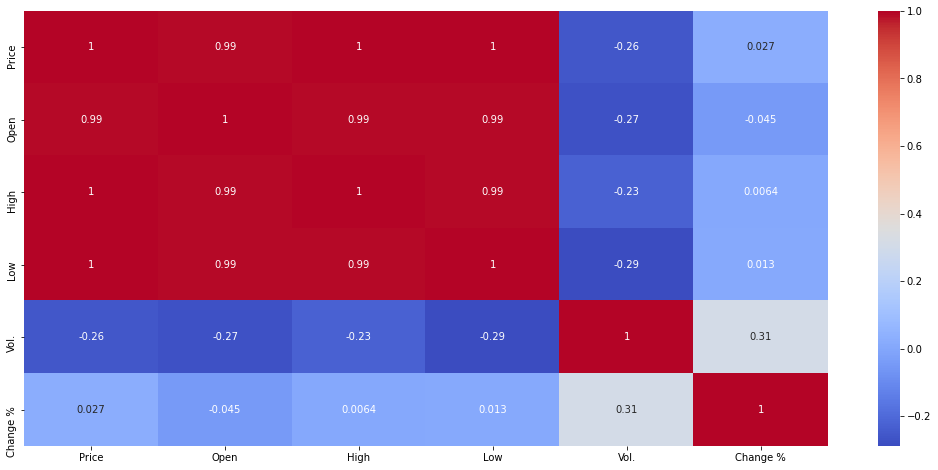

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


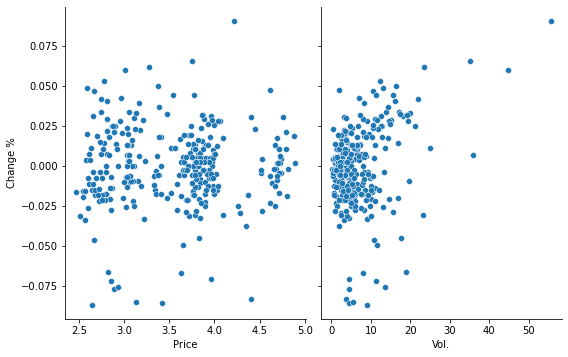

In [206]:
exploration(data)

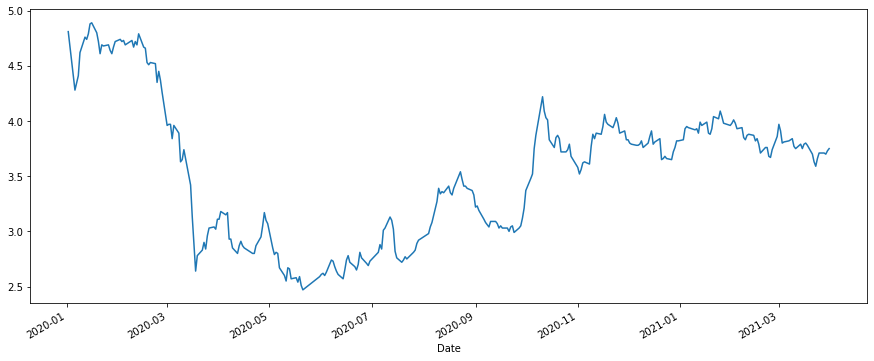

In [207]:
y = data['Price'][:]
y.plot(figsize=(15, 6))
plt.show()

In [208]:
print(y)

Date
2020-01-02    4.81
2020-01-05    4.41
2020-01-06    4.28
2020-01-08    4.41
2020-01-09    4.62
              ... 
2021-03-25    3.71
2021-03-28    3.71
2021-03-29    3.70
2021-03-30    3.73
2021-03-31    3.75
Name: Price, Length: 305, dtype: float64


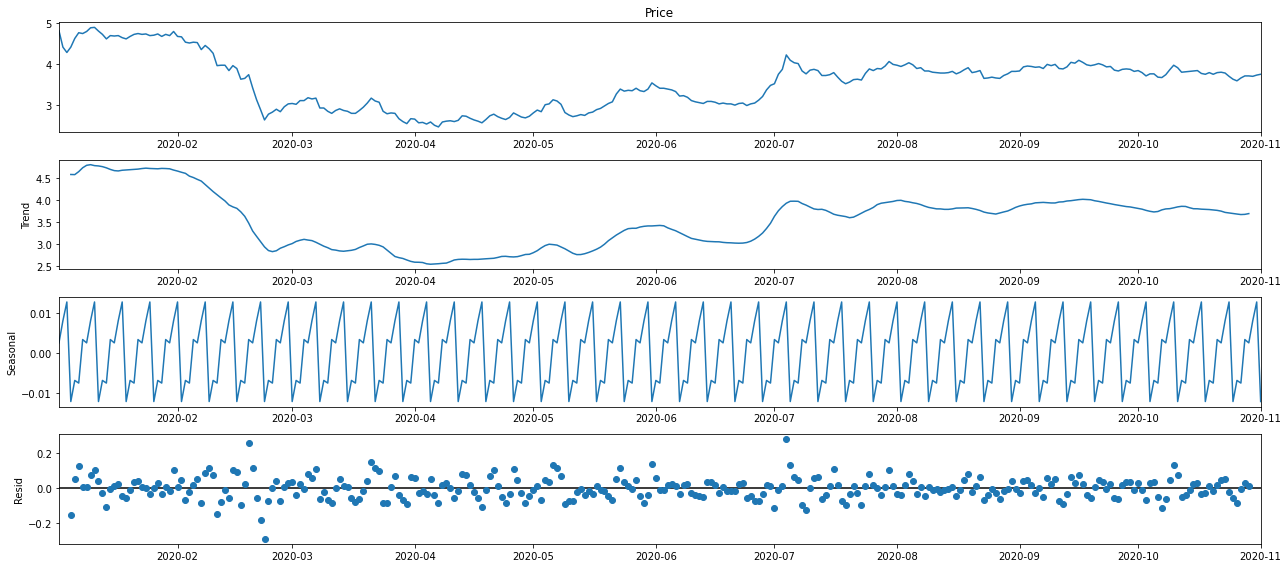

In [209]:
y.index = pd.date_range(start='2020-01-02', periods=len(y), freq='D')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# 3 - Feature engineering: making weekly, monthly

In [210]:
# Resample the data on a weekly basis
dataW0 = data0.resample('W').last()
dataW1 = data1.resample('W').last()
dataW2 = data2.resample('W').last()
# Resample the data on a monthly basis 
dataM0 = data0.resample('M').last()
dataM1 = data1.resample('M').last()
dataM2 = data2.resample('M').last()

In [211]:
dataW = dataW2
dataM = dataM2

In [212]:
print(dataW)

            Price  Open  High   Low     Vol.  Change %
Date                                                  
2020-01-05   4.41  4.70  4.70  4.33  3.76000   -0.0832
2020-01-12   4.76  4.60  4.87  4.57  3.16000    0.0303
2020-01-19   4.80  4.85  4.85  4.77  1.14000   -0.0184
2020-01-26   4.69  4.74  4.74  4.64  0.91479    0.0021
2020-02-02   4.74  4.70  4.84  4.66  6.02000    0.0042
...           ...   ...   ...   ...      ...       ...
2021-03-07   3.82  3.86  3.87  3.79  2.40000    0.0026
2021-03-14   3.79  3.76  3.83  3.75  2.04000    0.0107
2021-03-21   3.70  3.79  3.80  3.65  1.93000   -0.0212
2021-03-28   3.71  3.76  3.76  3.68  2.34000    0.0000
2021-04-04   3.75  3.74  3.82  3.71  1.57000    0.0054

[66 rows x 6 columns]


In [213]:
dataM

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-31,4.72,4.70,4.77,4.68,1.90,0.0107
2020-02-29,4.26,4.40,4.40,4.25,9.79,-0.0252
2020-03-31,3.11,3.05,3.14,3.05,3.75,0.0298
2020-04-30,3.07,3.07,3.11,3.04,5.40,-0.0097
2020-05-31,2.59,2.53,2.65,2.53,13.02,0.0486
2020-06-30,2.73,2.69,2.76,2.69,4.08,0.0149
2020-07-31,2.92,2.94,2.97,2.88,5.92,0.0104
2020-08-31,3.33,3.40,3.45,3.26,7.85,-0.0119
2020-09-30,3.21,3.15,3.26,3.15,15.04,0.0288


# 4 - Models

In [214]:
data.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [215]:
data.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-25,3.71,3.62,3.78,3.59,2.50,0.0137
2021-03-28,3.71,3.76,3.76,3.68,2.34,0.0000
2021-03-29,3.70,3.69,3.73,3.68,1.25,-0.0027
2021-03-30,3.73,3.71,3.76,3.67,3.43,0.0081
2021-03-31,3.75,3.74,3.82,3.71,1.57,0.0054


In [216]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def pre_LSTM(df):
    data = df['Price']
    data = data.values
    data = data.astype('float32')
    data = data.reshape(-1, 1)
    return data

In [217]:
results = {}
results_W = {}
results_M = {}

## Moving average models

In [218]:
def moving_av(dataset, look_back):
    train = np.array(dataset[dataset.index < '2021-01-01']['Price'])
    testY = np.array(dataset[dataset.index >= '2021-01-01']['Price'])

    # Prepare input data
    inputs = train[-look_back:]
    
    # Predict next values
    forecasts = []
    for i in range(len(testY)):
        # Forecast next value
        forecast = inputs.mean()
        forecasts.append(forecast)
        # Update input sequence
        inputs = np.append(inputs[1:],forecast)
        # Update input sequence
    
    # Print forecasts
    print(f"Next {len(forecasts)} values: ", forecasts)   
    mse = round(np.sqrt(mean_squared_error(testY, forecasts)), 2)
    mape = round(mean_absolute_error(testY, forecasts), 2)
    print(f'Test Scores: MSE {mse}, MAP: {mape}')

    
    #make dataframe for results
    df_forecast = pd.DataFrame(forecasts,columns=['Prediction'])
    df_forecast.index = dataset[dataset.index >= '2021-01-01'].index
    
    forecasts = np.array(forecasts)
    forecasts = forecasts.reshape(-1, 1)
    
    dataset = pre_LSTM(dataset)
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(testY):, :] = forecasts
    
    # plot baseline and predictions
    plt.plot(dataset, color = 'b')
    plt.plot(testPredictPlot, color = 'r')
    plt.show()
    
    return df_forecast, mse, mape

def mov_exp(dataset, model_type = 1):
    
    train = pre_LSTM(dataset[dataset.index < '2021-01-01'])
    testY = pre_LSTM(dataset[dataset.index >= '2021-01-01'])
    
    model = SimpleExpSmoothing(np.asarray(train))

    if model_type == 1:
        fit = model.fit()
    elif model_type == 2:
        fit = model.fit(smoothing_level=.2)
    elif model_type == 3:
        fit = model.fit(smoothing_level=.5)

    forecasts = fit.forecast(len(testY))
    
    # Print forecasts
    print(f"Next {len(forecasts)} values: ", forecasts)   
    mse = round(np.sqrt(mean_squared_error(testY, forecasts)), 2)
    mape = round(mean_absolute_error(testY, forecasts), 2)
    print(f'Test Scores: MSE {mse}, MAP: {mape}')

    
    #make dataframe for results
    df_forecast = pd.DataFrame(forecasts,columns=['Prediction'])
    df_forecast.index = dataset[dataset.index >= '2021-01-01'].index
    
    forecasts = np.array(forecasts)
    forecasts = forecasts.reshape(-1, 1)
    
    dataset = pre_LSTM(dataset)
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(testY):, :] = forecasts
    
    # plot baseline and predictions
    plt.plot(dataset, color = 'b')
    plt.plot(testPredictPlot, color = 'r')
    plt.show()
    
    return df_forecast, mse, mape

### Daily basis

Next 62 values:  [3.811333333333333, 3.8070444444444447, 3.8012792592592595, 3.7936552345679013, 3.7874437423868317, 3.7840252004663926, 3.7798260404819386, 3.7781535751646698, 3.776425361003492, 3.7756395397036084, 3.775160857693728, 3.774999552950186, 3.7748328713818595, 3.7743273004279216, 3.772804877108853, 3.773231706345815, 3.772339429890675, 3.769417410887031, 3.7647313245832654, 3.7638890354027073, 3.7623520032494637, 3.7597637366911125, 3.7634225279141496, 3.7668699455112877, 3.769765610361664, 3.773424464040386, 3.777538612841732, 3.7794565666031237, 3.780105118823228, 3.778775289450669, 3.7774011324323578, 3.776270059068992, 3.775244246223144, 3.774376412455273, 3.7737337850515185, 3.7732767864736743, 3.772918506007251, 3.7726882548580942, 3.7725060775145414, 3.7723754347315768, 3.772266631232509, 3.7721701570171353, 3.7720758438193664, 3.7719839429006172, 3.77190583098304, 3.7718758627788467, 3.771830667993281, 3.7718137092633683, 3.771893585875913, 3.7721323279190013, 3.77

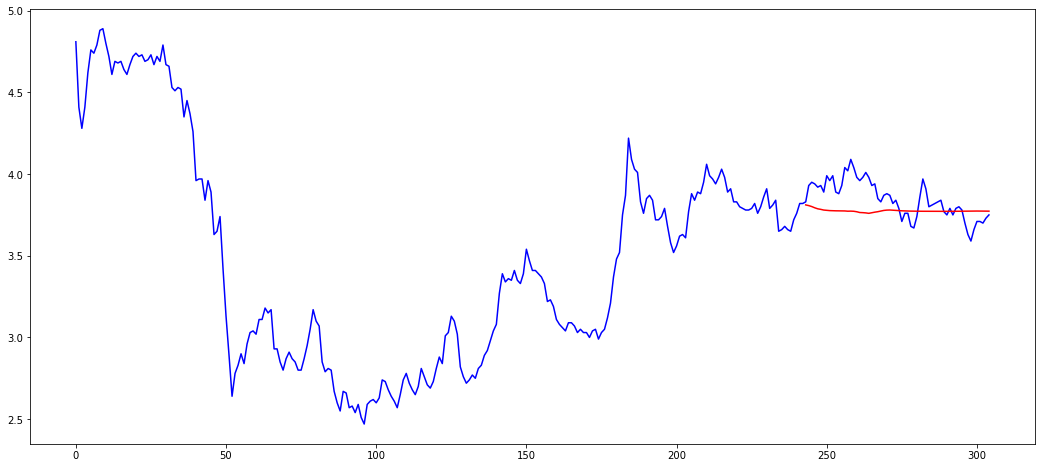

In [219]:
f20, r1, r2 = moving_av(data, 30)
results[20] = ['mov_av', 30, 'na', 'f20', r1, r2]

Next 62 values:  [3.8184999999999993, 3.817641666666666, 3.8109356944444444, 3.806284622685185, 3.8025560330632713, 3.7990986336143266, 3.7985836108412316, 3.799226671021919, 3.7983804488722845, 3.797186789686822, 3.796473236181603, 3.797747790117963, 3.799043586619929, 3.8000276463969276, 3.8001947738368766, 3.802198020067491, 3.805901320401949, 3.8106663424086475, 3.8148441147821255, 3.818091516695161, 3.8212263753067464, 3.824746814895192, 3.8256592618101117, 3.8247535828402808, 3.824499475887619, 3.823407800485746, 3.8224645971605087, 3.8203390071131844, 3.8163446572317374, 3.8134504015189323, 3.8108412415442476, 3.808688595569985, 3.8058334054961516, 3.8020972955877546, 3.7991322505142167, 3.7976177880227864, 3.7957447511565, 3.795173830342442, 3.7945933941814824, 3.7945032840845068, 3.7945783388192487, 3.7948213111329028, 3.795068332985118, 3.795152805201537, 3.794738685288229, 3.795317663376366, 3.7952396244326394, 3.7941602848398497, 3.7922296229205137, 3.7922667833025225, 3.79

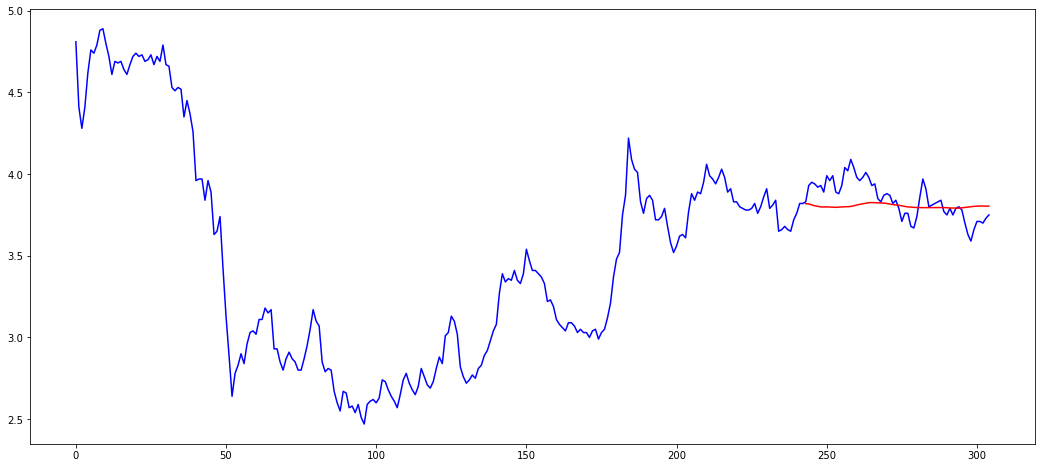

In [220]:
f21, r1, r2 = moving_av(data, 60)
results[21] = ['mov_av', 60, 'na', 'f21', r1, r2]

Next 62 values:  [3.6059999999999994, 3.608177777777777, 3.6106019753086414, 3.6132753305898495, 3.6164228342630693, 3.6208275324215475, 3.625170060559565, 3.6300052834546723, 3.6357831199375017, 3.6419584879368068, 3.6484246933583266, 3.6551849677289745, 3.661464800703742, 3.66781440960045, 3.674456791929343, 3.6816174229507808, 3.6886353943169006, 3.6959535653648667, 3.703353049424475, 3.7111680833069696, 3.718625506454825, 3.7260546787487674, 3.7342330640681984, 3.7420578758911778, 3.7497474078455246, 3.7567446012660306, 3.7628195412800975, 3.7671842028498763, 3.770375138437098, 3.773157084419731, 3.7734143853577287, 3.772341211861704, 3.7673672253268338, 3.763782416719354, 3.7608244435717917, 3.7580558262781443, 3.7572564465701244, 3.7572259626431257, 3.7561951400058264, 3.7549306415614474, 3.7539854264676853, 3.7543630423173258, 3.7547448538986297, 3.7549086856086142, 3.754518782115377, 3.7553467685833253, 3.7572950660120292, 3.759931677856607, 3.7621531409439033, 3.76373262028772

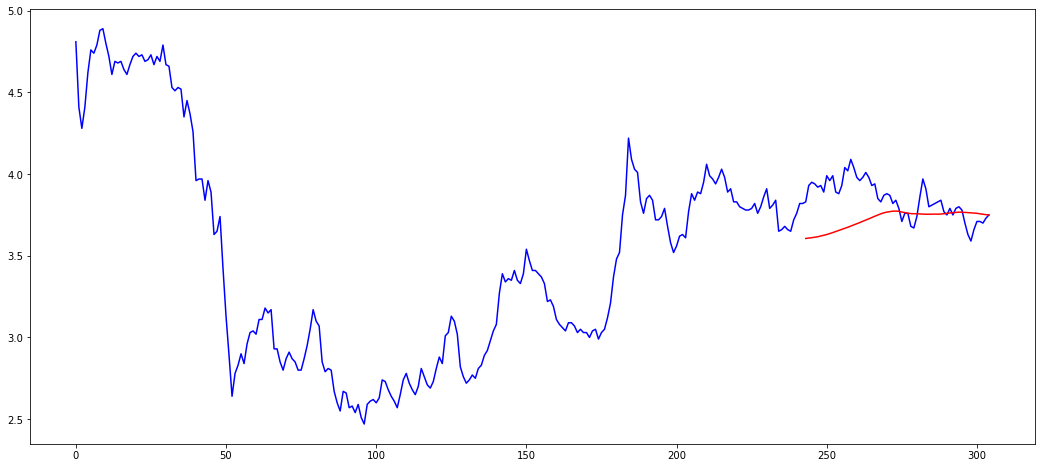

In [221]:
f22, r1, r2 = moving_av(data, 90)
results[22] = ['mov_av', 90, 'na', 'f22', r1, r2]

Next 62 values:  [3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999]
Test Scores: MSE 0.12, MAP: 0.1


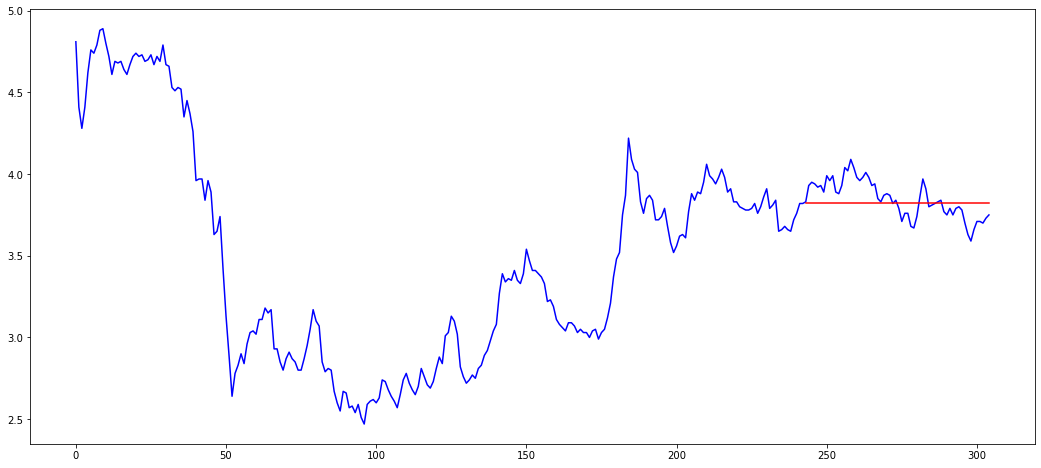

In [222]:
f23, r1, r2 = mov_exp(data)
results[23] = ['mov_exp', 90, '1', 'f23', r1, r2]

Next 62 values:  [3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877]
Test Scores: MSE 0.14, MAP: 0.12


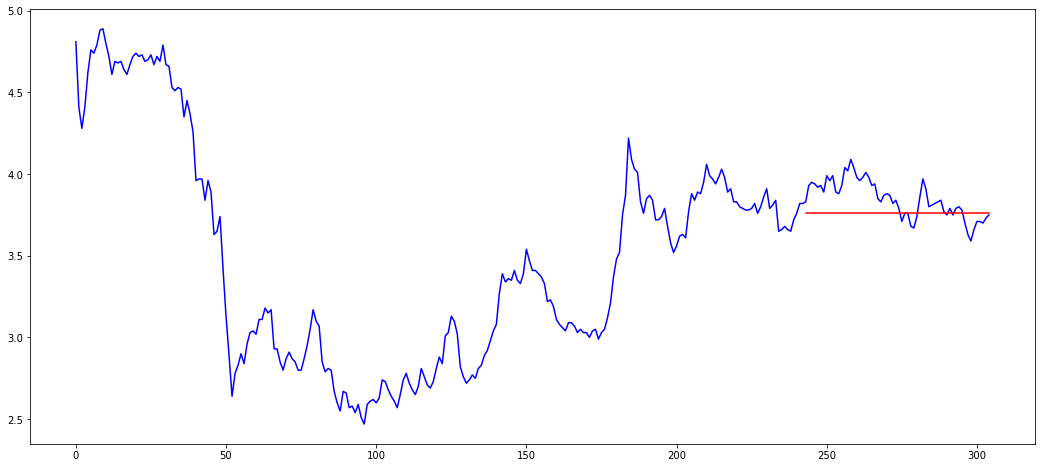

In [223]:
f24, r1, r2 = mov_exp(data, 2)
results[24] = ['mov_exp', 90, '2', 'f24', r1, r2]

Next 62 values:  [3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566]
Test Scores: MSE 0.12, MAP: 0.1


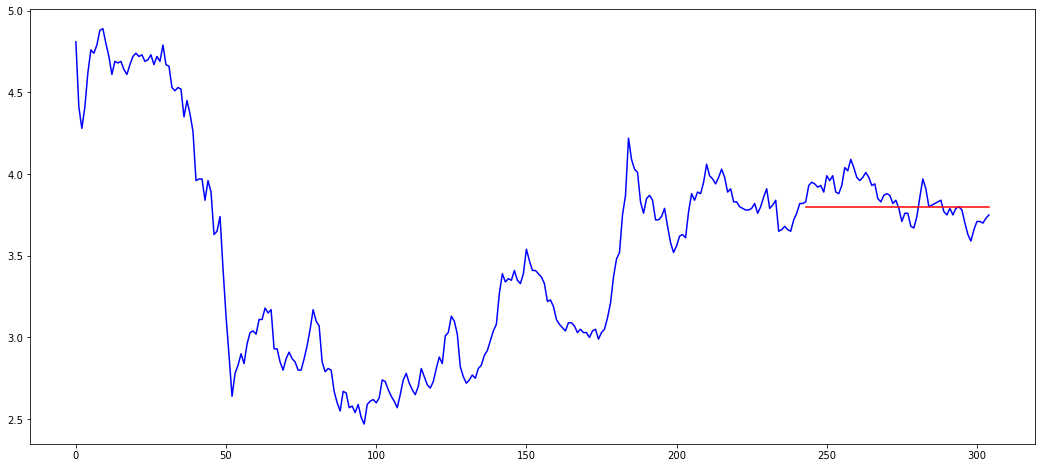

In [224]:
f25, r1, r2 = mov_exp(data, 3)
results[25] = ['mov_exp', 90, '3', 'f25', r1, r2]

### Weekly basis

Next 62 values:  [3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82]
Test Scores: MSE 0.12, MAP: 0.1


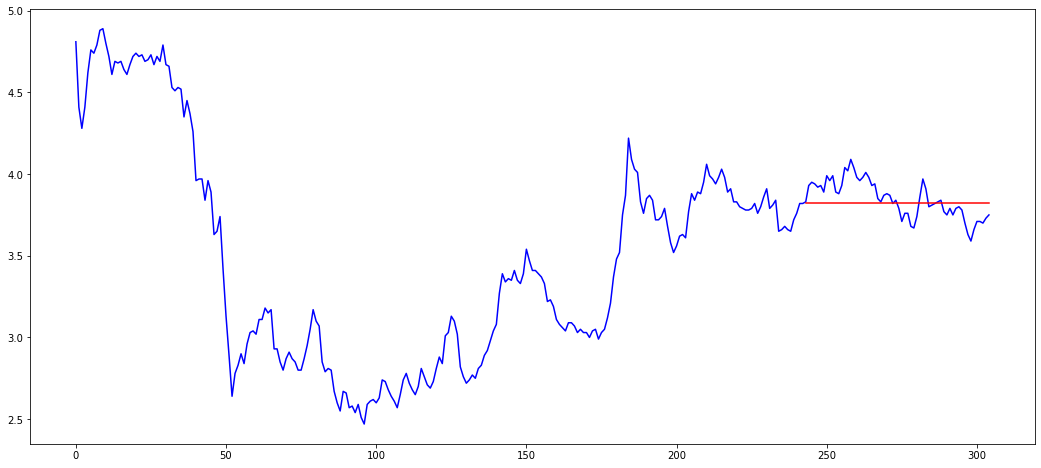

In [225]:
w20, r1, r2 = moving_av(data, 2)
results_W[20] = ['mov_av', 2, 'na', 'w20', r1, r2]

Next 62 values:  [3.7383333333333333, 3.7513888888888887, 3.7682870370370374, 3.77633487654321, 3.7790573559670784, 3.7722335819615918, 3.764272512288523, 3.7685957087810547, 3.771463512096416, 3.7719929246063124, 3.771269265950163, 3.7699712509473433, 3.7695941957783017, 3.7704811430265983, 3.770795382067522, 3.770684027062707, 3.770465877472106, 3.7703319793924295, 3.770392100799944, 3.770525084970218, 3.770532408627487, 3.770488579720815, 3.7704560051638336, 3.770454359779121, 3.7704747565102372, 3.770488532461952, 3.7704824403772412, 3.770474112335533, 3.7704717011046527, 3.77047431709479, 3.7704776433140683, 3.77047812444804, 3.7704763897790543, 3.770475381346023, 3.770475592847772, 3.770476241471625, 3.7704765622010967, 3.7704763820156018, 3.7704760916101954, 3.7704760419153853, 3.77047615201028, 3.7704762452040304, 3.770476245826098, 3.770476193096932, 3.770476161610487, 3.7704761732772014, 3.7704761951708385, 3.770476202364265, 3.7704761952243033, 3.7704761867906718, 3.77047618

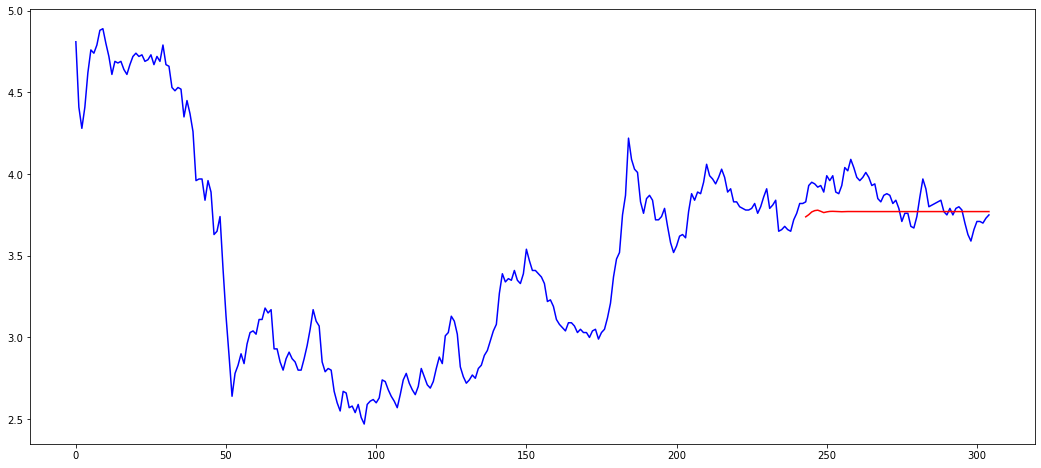

In [226]:
w21, r1, r2 = moving_av(data, 6)
results_W[21] = ['mov_av', 6, 'na', 'w21', r1, r2]

Next 62 values:  [3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999]
Test Scores: MSE 0.12, MAP: 0.1


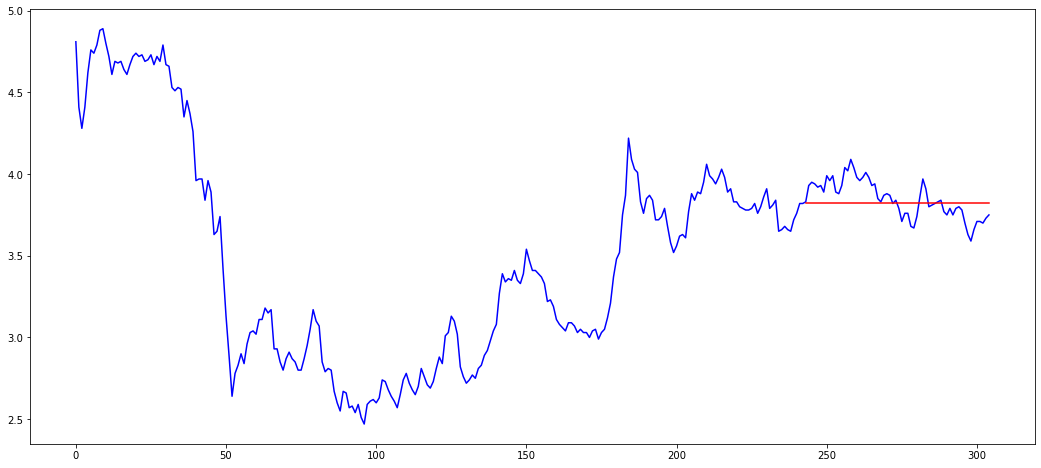

In [227]:
w22, r1, r2 = mov_exp(data, 1)
results_W[22] = ['mov_exp', 90, '1', 'w22', r1, r2]

Next 62 values:  [3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877]
Test Scores: MSE 0.14, MAP: 0.12


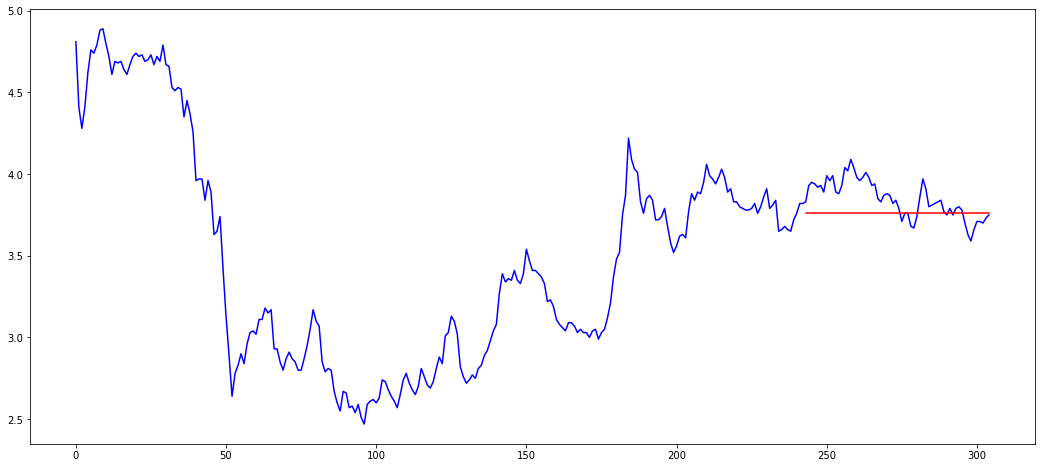

In [228]:
w23, r1, r2 = mov_exp(data, 2)
results_W[23] = ['mov_exp', 90, '2', 'w23', r1, r2]

Next 62 values:  [3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566]
Test Scores: MSE 0.12, MAP: 0.1


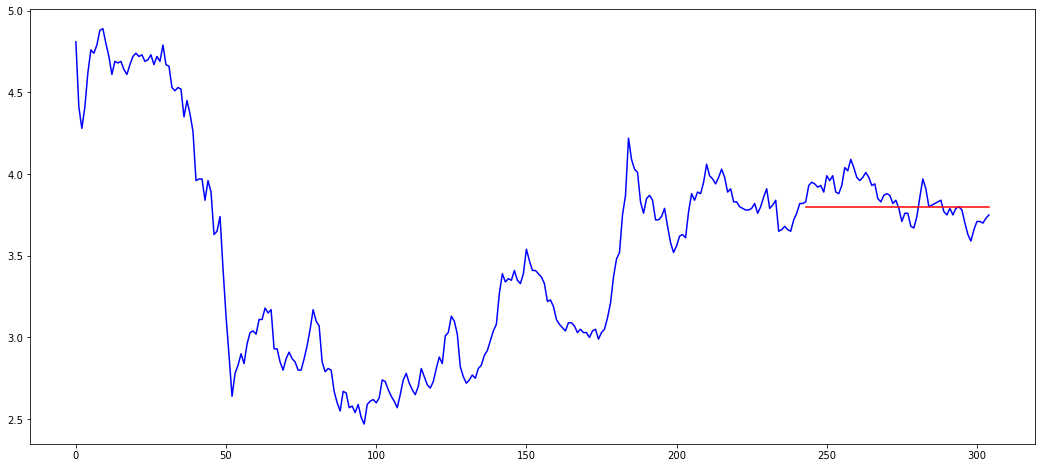

In [229]:
w24, r1, r2 = mov_exp(data, 3)
results_W[24] = ['mov_exp', 90, '3', 'w24', r1, r2]

### Monthly basis

Next 62 values:  [3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82, 3.82]
Test Scores: MSE 0.12, MAP: 0.1


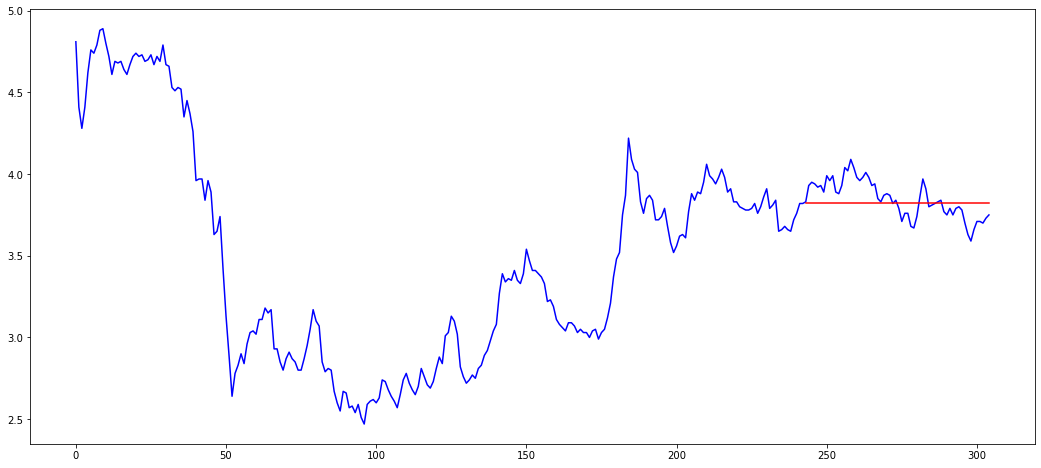

In [230]:
m20, r1, r2 = moving_av(data, 1)
results_M[20] = ['mov_av', 1, 'na', 'm20', r1, r2]

Next 62 values:  [3.8000000000000003, 3.813333333333333, 3.8111111111111113, 3.8081481481481485, 3.8108641975308646, 3.810041152263375, 3.809684499314129, 3.8101966163694563, 3.8099740893156535, 3.8099517349997463, 3.810040813561619, 3.8099888792923395, 3.809993809284568, 3.8100078340461754, 3.8099968408743607, 3.8099994947350346, 3.8100013898851905, 3.8099992418315285, 3.8100000421505844, 3.8100002246224345, 3.809999836201516, 3.8100000343248452, 3.8100000317162652, 3.8099999674142087, 3.810000011151773, 3.8100000034274157, 3.809999993997799, 3.8100000028589958, 3.8100000000947367, 3.809999998983844, 3.810000000645859, 3.809999999908147, 3.80999999984595, 3.8100000001333183, 3.8099999999624714, 3.8099999999805796, 3.810000000025456, 3.8099999999895022, 3.8099999999985124, 3.81000000000449, 3.809999999997501, 3.810000000000168, 3.8100000000007195, 3.8099999999994627, 3.8100000000001164, 3.8100000000000995, 3.8099999999998926, 3.810000000000036, 3.8100000000000094, 3.809999999999979, 3.

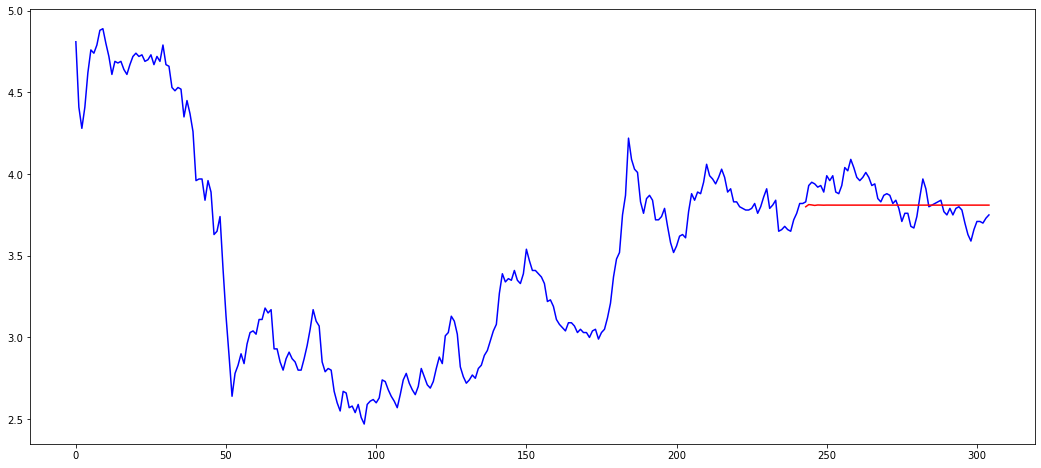

In [231]:
m21, r1, r2 = moving_av(data, 3)
results_M[21] = ['mov_av', 3, 'na', 'm21', r1, r2]

Next 62 values:  [3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999 3.81999999
 3.81999999 3.81999999]
Test Scores: MSE 0.12, MAP: 0.1


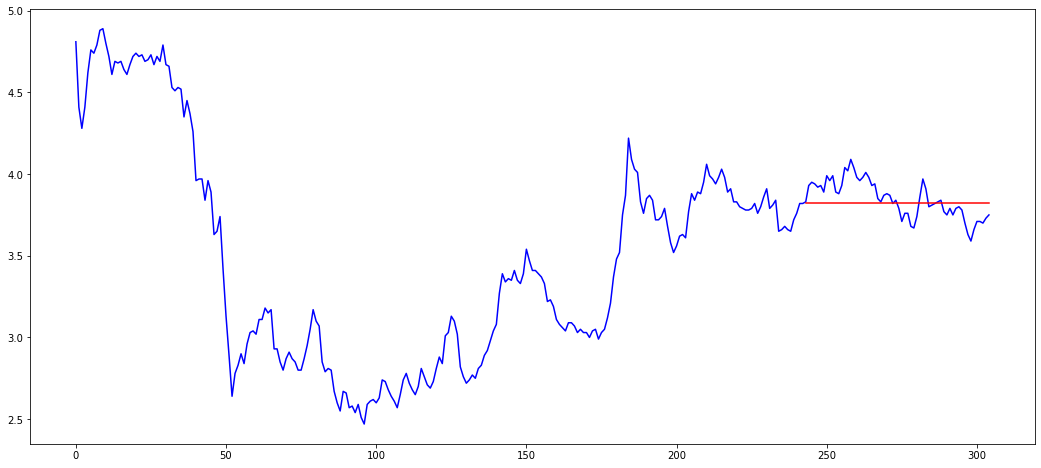

In [232]:
m22, r1, r2 = mov_exp(data, 1)
results_M[22] = ['mov_exp', 90, '1', 'm22', r1, r2]

Next 62 values:  [3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877 3.75886877
 3.75886877 3.75886877]
Test Scores: MSE 0.14, MAP: 0.12


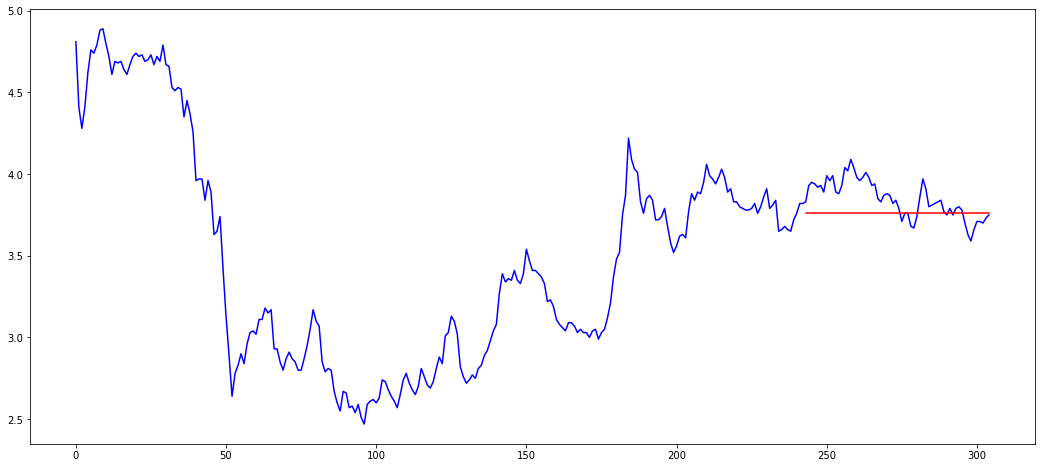

In [233]:
m23, r1, r2 = mov_exp(data, 2)
results_M[23] = ['mov_exp', 90, '2', 'm23', r1, r2]

Next 62 values:  [3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566 3.79640566
 3.79640566 3.79640566]
Test Scores: MSE 0.12, MAP: 0.1


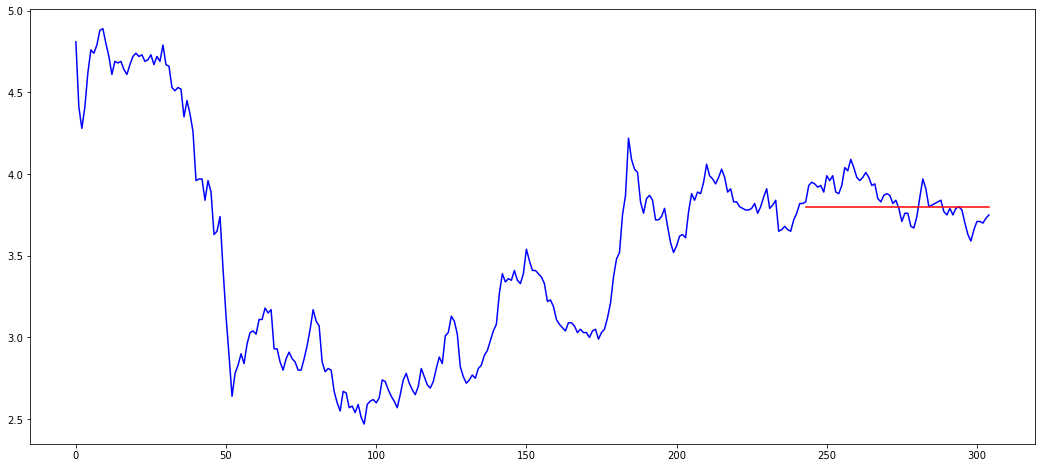

In [234]:
m24, r1, r2 = mov_exp(data, 3)
results_M[24] = ['mov_exp', 90, '3', 'm24', r1, r2]

## LSTM models

In [235]:
def model_LSTM(dataset, look_back=1, epochs = 5, model_type = False):
    
    train = pre_LSTM(dataset[dataset.index < '2021-01-01'])
    testY = pre_LSTM(dataset[dataset.index >= '2021-01-01'])
    
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    
    # # create and fit the LSTM network

    tf.random.set_seed(41)

    model = Sequential()
    if not model_type:
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))        
    elif model_type == 'seq':
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(50, activation='relu'))
    elif model_type =='bi':
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))        
    model.compile(optimizer='adam', loss='mse')
    model.fit(trainX, trainY, epochs=epochs, verbose=0)
    

    # make predictions

    # Prepare input data
    inputs = trainX[-1:]
    inputs = np.append(inputs[:,1:,:], [[[trainY[-1]]]], axis=1)

    # Predict next values
    forecasts = []
    for i in range(len(testY)):
        # Forecast next value
        forecast = model.predict(inputs, verbose = 0)
        forecast = forecast[-1][-1].round(2)
        forecasts.append(forecast)
        new = np.append(inputs[:,1:,:],[[[forecast]]],axis=1)
        # Update input sequence
        inputs = new
    
    # Print forecasts
    print(f"Next {len(forecasts)} values: ", forecasts)   
    mse = round(np.sqrt(mean_squared_error(testY, forecasts)), 2)
    mape = round(mean_absolute_error(testY, forecasts), 2)
    print(f'Test Scores: MSE {mse}, MAP: {mape}')

    
    #make dataframe for results
    df_forecast = pd.DataFrame(forecasts,columns=['Prediction'])
    df_forecast.index = dataset[dataset.index >= '2021-01-01'].index
    
    forecasts = np.array(forecasts)
    forecasts = forecasts.reshape(-1, 1)
    
    dataset = pre_LSTM(dataset)
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(testY):, :] = forecasts
    
    # plot baseline and predictions
    plt.plot(dataset, color = 'b')
    plt.plot(testPredictPlot, color = 'r')
    plt.show()
    
    return df_forecast, mse, mape

### Daily basis

Next 62 values:  [3.76, 3.77, 3.77, 3.76, 3.75, 3.74, 3.72, 3.7, 3.68, 3.67, 3.65, 3.63, 3.61, 3.6, 3.58, 3.56, 3.55, 3.53, 3.52, 3.5, 3.49, 3.48, 3.47, 3.46, 3.45, 3.44, 3.43, 3.42, 3.41, 3.4, 3.39, 3.38, 3.38, 3.37, 3.36, 3.36, 3.35, 3.35, 3.34, 3.34, 3.33, 3.33, 3.33, 3.32, 3.32, 3.32, 3.32, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31]
Test Scores: MSE 0.4099999964237213, MAP: 0.38999998569488525


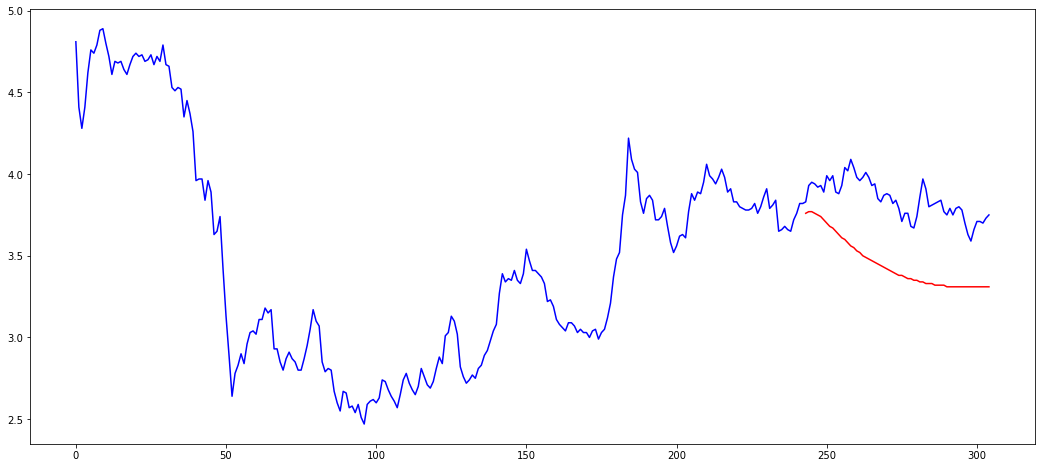

In [236]:
mtype = 'standard'
f0, r1, r2 = model_LSTM(data, 10, 200)
results[0] = ['lstm', 10, mtype, 'f0', r1, r2]

Next 62 values:  [3.81, 3.84, 3.85, 3.85, 3.86, 3.86, 3.86, 3.86, 3.85, 3.85, 3.84, 3.84, 3.83, 3.82, 3.81, 3.8, 3.79, 3.78, 3.77, 3.76, 3.75, 3.74, 3.73, 3.73, 3.72, 3.72, 3.71, 3.71, 3.71, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7]
Test Scores: MSE 0.12999999523162842, MAP: 0.10999999940395355


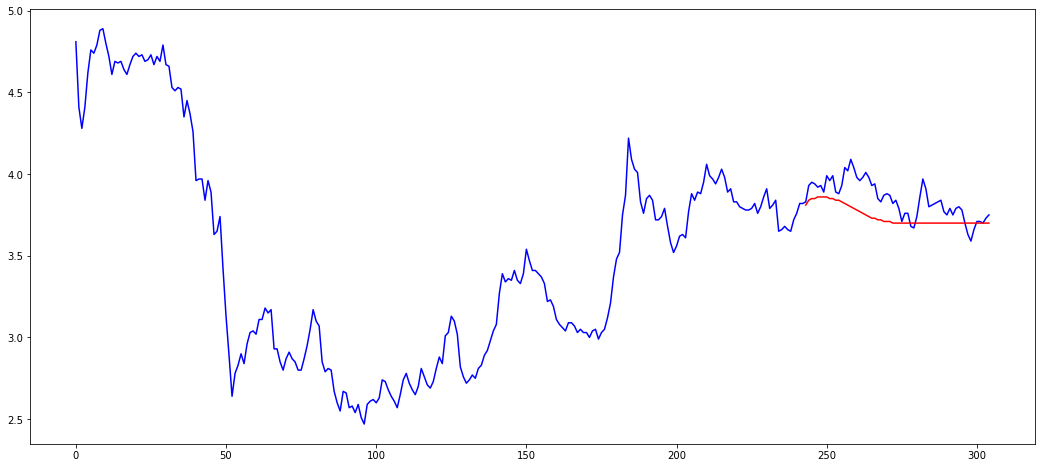

In [237]:
mtype = 'seq'
f1, r1, r2 = model_LSTM(data, 10, 200, model_type =mtype)
results[1] = ['lstm', 10, mtype, 'f1', r1, r2]

Next 62 values:  [3.78, 3.79, 3.78, 3.77, 3.75, 3.73, 3.71, 3.69, 3.67, 3.65, 3.63, 3.61, 3.59, 3.57, 3.55, 3.53, 3.51, 3.5, 3.48, 3.47, 3.45, 3.44, 3.43, 3.42, 3.41, 3.4, 3.39, 3.39, 3.38, 3.38, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37]
Test Scores: MSE 0.4000000059604645, MAP: 0.3799999952316284


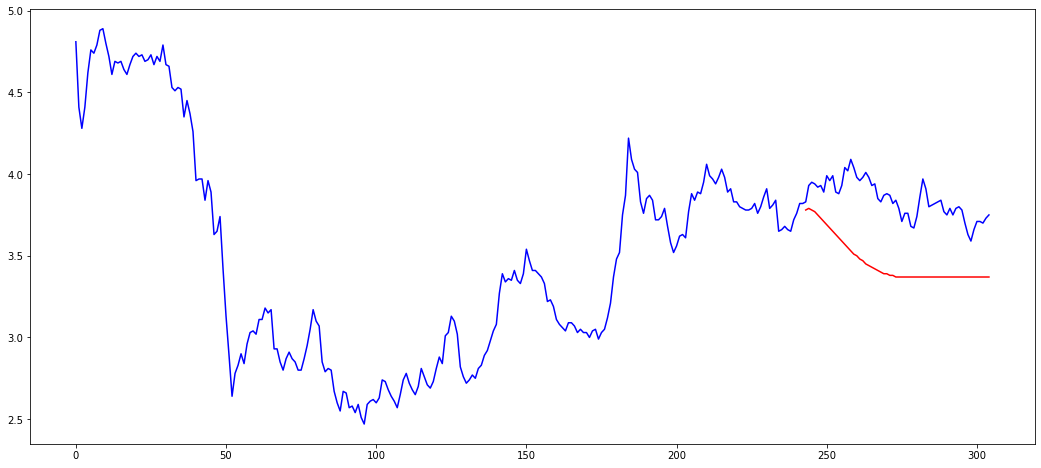

In [238]:
mtype = 'bi'
f2, r1, r2 = model_LSTM(data, 10, 200, model_type =mtype)
results[2] = ['lstm', 10, mtype, 'f2', r1, r2]

Next 62 values:  [3.9, 3.97, 4.05, 4.12, 4.2, 4.27, 4.34, 4.41, 4.48, 4.55, 4.62, 4.69, 4.76, 4.82, 4.87, 4.91, 4.95, 4.98, 5.01, 5.05, 5.09, 5.13, 5.18, 5.23, 5.29, 5.36, 5.43, 5.5, 5.58, 5.66, 5.74, 5.82, 5.9, 5.98, 6.06, 6.15, 6.24, 6.33, 6.42, 6.51, 6.6, 6.7, 6.8, 6.9, 7.0, 7.11, 7.22, 7.34, 7.47, 7.61, 7.76, 7.93, 8.12, 8.34, 8.59, 8.88, 9.23, 9.65, 10.17, 10.8, 11.57, 12.49]
Test Scores: MSE 3.1500000953674316, MAP: 2.440000057220459


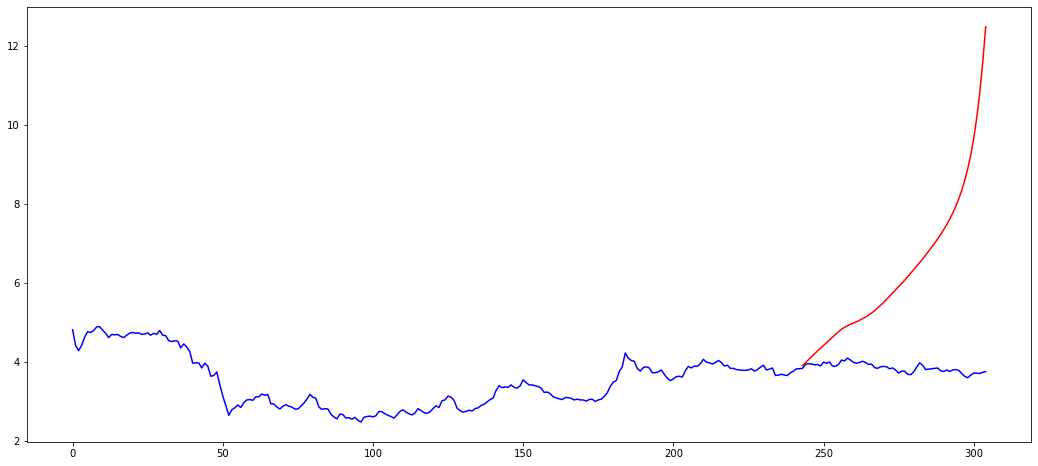

In [239]:
mtype = 'standard'
f3, r1, r2 = model_LSTM(data, 30, 200)
results[3] = ['lstm', 30, 'standard', 'f3', r1, r2]

Next 62 values:  [3.87, 3.89, 3.92, 3.94, 3.96, 3.97, 3.98, 3.99, 4.0, 4.0, 4.0, 4.0, 4.0, 3.99, 3.98, 3.96, 3.95, 3.93, 3.91, 3.89, 3.87, 3.84, 3.82, 3.79, 3.77, 3.75, 3.73, 3.72, 3.71, 3.71, 3.71, 3.71, 3.72, 3.73, 3.75, 3.77, 3.79, 3.82, 3.84, 3.87, 3.89, 3.91, 3.93, 3.95, 3.96, 3.97, 3.98, 3.99, 3.99, 4.0, 4.0, 4.0, 3.99, 3.98, 3.97, 3.95, 3.93, 3.91, 3.88, 3.86, 3.83, 3.81]
Test Scores: MSE 0.14000000059604645, MAP: 0.11999999731779099


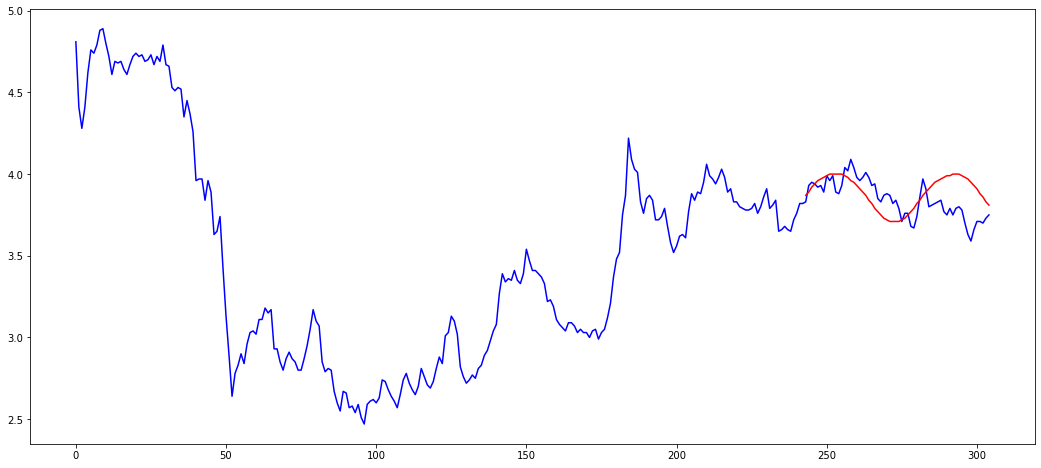

In [240]:
mtype = 'seq'
f4, r1, r2 = model_LSTM(data, 30, 200, model_type =mtype)
results[4] = ['lstm', 30, mtype, 'f4', r1, r2]

Next 62 values:  [3.92, 3.99, 4.06, 4.12, 4.17, 4.21, 4.23, 4.24, 4.24, 4.22, 4.19, 4.16, 4.13, 4.1, 4.06, 4.03, 3.99, 3.95, 3.91, 3.87, 3.82, 3.78, 3.74, 3.71, 3.68, 3.67, 3.66, 3.67, 3.69, 3.73, 3.78, 3.85, 3.92, 4.0, 4.08, 4.15, 4.21, 4.26, 4.29, 4.31, 4.31, 4.29, 4.25, 4.21, 4.17, 4.13, 4.09, 4.05, 4.0, 3.95, 3.9, 3.85, 3.8, 3.75, 3.7, 3.66, 3.62, 3.6, 3.59, 3.6, 3.62, 3.66]
Test Scores: MSE 0.23999999463558197, MAP: 0.20000000298023224


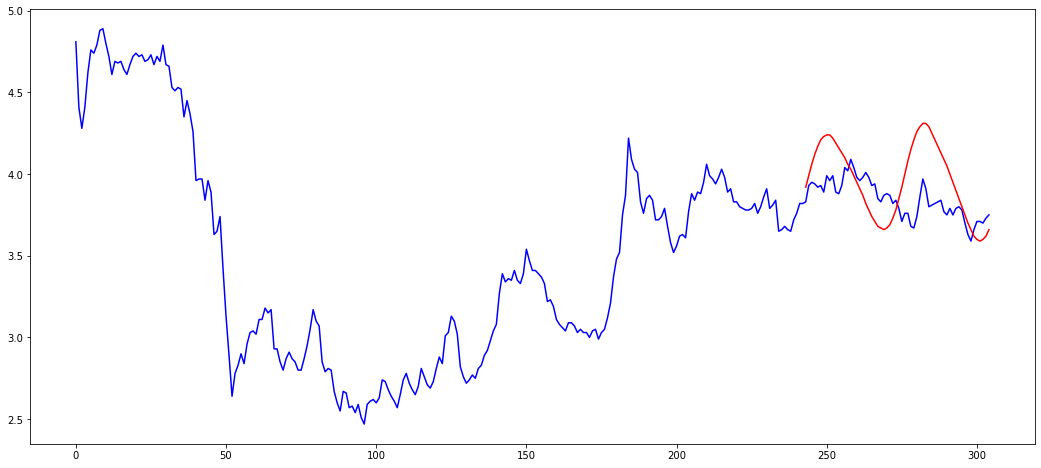

In [241]:
mtype = 'bi'
f5, r1, r2 = model_LSTM(data, 30, 200, model_type =mtype)
results[5] = ['lstm', 30, mtype, 'f5', r1, r2]

Next 62 values:  [3.84, 3.86, 3.87, 3.88, 3.88, 3.88, 3.87, 3.86, 3.85, 3.84, 3.82, 3.81, 3.8, 3.79, 3.78, 3.78, 3.78, 3.78, 3.79, 3.79, 3.8, 3.81, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.87, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.88, 3.89, 3.89, 3.9, 3.9, 3.91, 3.91, 3.92, 3.92, 3.93, 3.93, 3.93, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94, 3.94]
Test Scores: MSE 0.1599999964237213, MAP: 0.12999999523162842


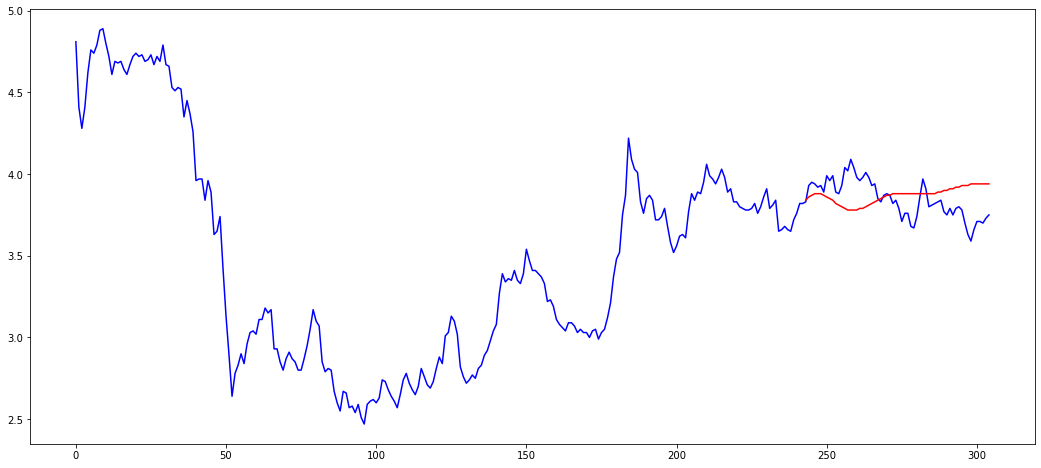

In [242]:
mtype = 'standard'
f6, r1, r2 = model_LSTM(data, 60, 200)
results[6] = ['lstm', 60, 'standard', 'f6', r1, r2]

Next 62 values:  [3.77, 3.79, 3.8, 3.81, 3.82, 3.82, 3.82, 3.82, 3.82, 3.81, 3.8, 3.79, 3.79, 3.78, 3.78, 3.77, 3.77, 3.77, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.76, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75]
Test Scores: MSE 0.12999999523162842, MAP: 0.10999999940395355


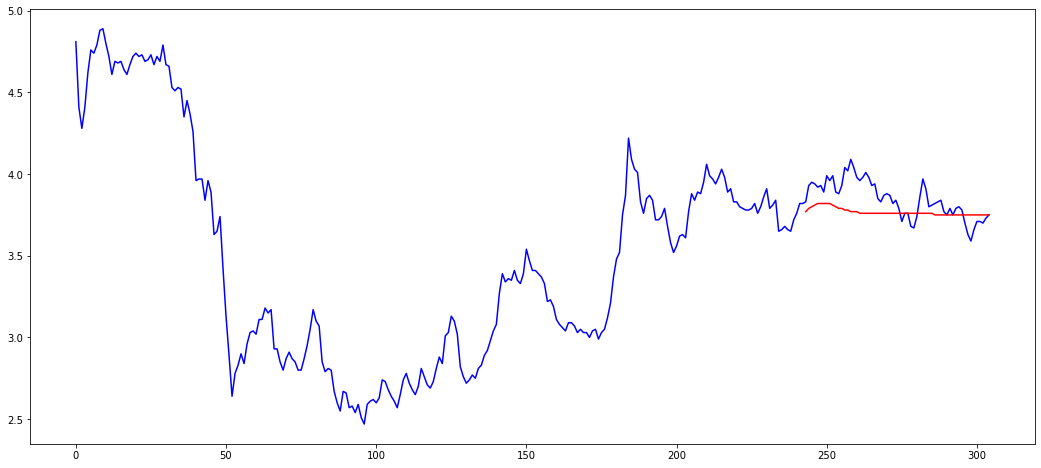

In [243]:
mtype = 'seq'
f7, r1, r2 = model_LSTM(data, 60, 200, model_type =mtype)
results[7] = ['lstm', 60, mtype, 'f7', r1, r2]

Next 62 values:  [5.45, 5.41, 5.53, 5.65, 5.61, 5.61, 5.64, 5.65, 5.64, 5.65, 5.65, 5.66, 5.68, 5.71, 5.74, 5.79, 5.86, 5.95, 6.08, 6.21, 6.4, 6.64, 6.9, 7.19, 7.5, 7.82, 8.15, 8.49, 8.85, 9.28, 9.78, 10.39, 11.16, 11.71, 12.46, 13.66, 13.83, 15.28, 15.38, 15.43, 15.03, 14.45, 15.13, 13.91, 8.93, 18.79, 6.28, 28.95, 23.66, -13.62, 43.55, 46.15, -55.45, 19.11, 15.44, -71.5, 34.61, -67.9, 68.1, 35.43, -1.23, 81.91]
Test Scores: MSE 23.219999313354492, MAP: 13.199999809265137


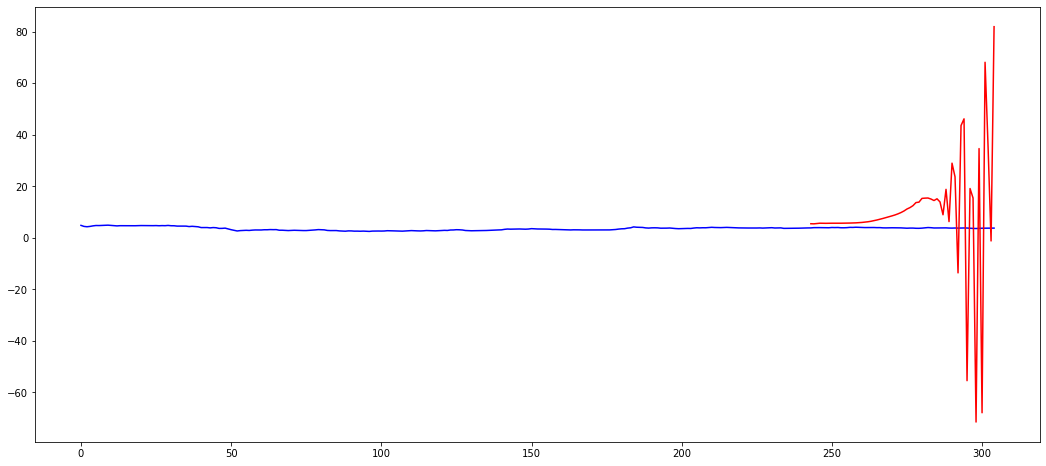

In [244]:
mtype = 'bi'
f8, r1, r2 = model_LSTM(data, 60, 200, model_type =mtype)
results[8] = ['lstm', 60, mtype, 'f8', r1, r2]

Next 62 values:  [3.55, 3.5, 3.46, 3.42, 3.38, 3.34, 3.3, 3.26, 3.23, 3.19, 3.15, 3.11, 3.08, 3.04, 3.0, 2.96, 2.93, 2.89, 2.85, 2.82, 2.78, 2.74, 2.71, 2.67, 2.64, 2.6, 2.57, 2.53, 2.5, 2.46, 2.43, 2.4, 2.36, 2.33, 2.3, 2.27, 2.24, 2.21, 2.18, 2.15, 2.12, 2.09, 2.06, 2.04, 2.01, 1.99, 1.96, 1.94, 1.92, 1.89, 1.87, 1.85, 1.83, 1.81, 1.79, 1.77, 1.75, 1.74, 1.72, 1.7, 1.69, 1.67]
Test Scores: MSE 1.4500000476837158, MAP: 1.3700000047683716


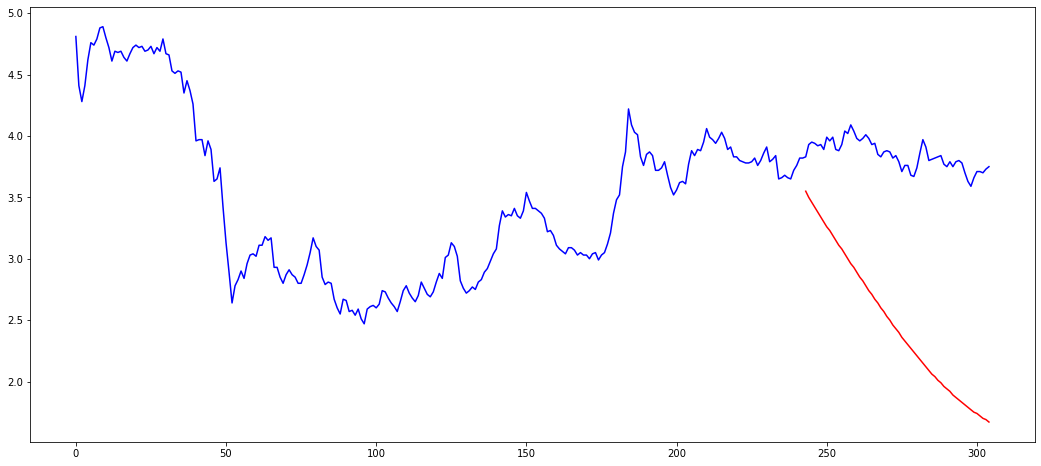

In [245]:
mtype = 'standard'
f9, r1, r2 = model_LSTM(data, 90, 200)
results[9] = ['lstm', 90, 'standard', 'f9', r1, r2]

Next 62 values:  [21.68, 141.03, 45.46, -18.96, 4.71, 29.17, 40.69, 23.11, 14.58, 36.91, 45.05, 17.65, 178.58, 34.49, 39.5, 154.95, -62.33, 12.24, 37.47, 97.94, 170.17, 27.9, 150.24, 1.55, -18.38, 294.96, 10.16, 148.75, 164.05, 185.3, -11.86, -16.75, 16.8, -26.56, -7.89, 34.6, 25.6, 7.39, -11.01, -15.27, -28.96, -48.48, -1.2, -10.88, 13.77, 79.79, 38.54, 83.0, -87.09, -36.86, -73.13, -85.43, 23.57, -39.14, -10.02, -107.78, 56.32, -24.02, 1.49, 233.83, -33.67, 50.17]
Test Scores: MSE 83.38999938964844, MAP: 56.560001373291016


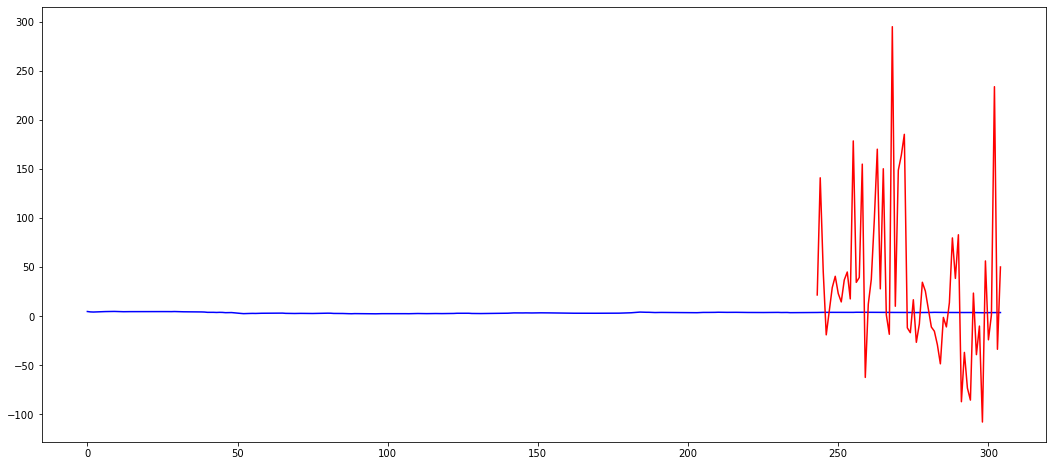

In [246]:
mtype = 'seq'
f10, r1, r2 = model_LSTM(data, 90, 200, model_type =mtype)
results[10] = ['lstm', 90, mtype, 'f10', r1, r2]
#results[10] = ['lstm', 90, mtype, 'f10', 'na', 'na']

Next 62 values:  [1.69, 1.62, 1.55, 1.48, 1.42, 1.37, 1.33, 1.29, 1.26, 1.24, 1.22, 1.21, 1.19, 1.18, 1.16, 1.15, 1.13, 1.12, 1.1, 1.1, 1.08, 1.07, 1.07, 1.08, 1.1, 1.12, 1.15, 1.18, 1.21, 1.25, 1.29, 1.32, 1.31, 1.3, 1.29, 1.28, 1.28, 1.28, 1.28, 1.27, 1.25, 1.25, 1.24, 1.23, 1.21, 1.19, 1.18, 1.18, 1.19, 1.19, 1.2, 1.22, 1.23, 1.23, 1.24, 1.24, 1.25, 1.26, 1.25, 1.25, 1.25, 1.26]
Test Scores: MSE 2.609999895095825, MAP: 2.5999999046325684


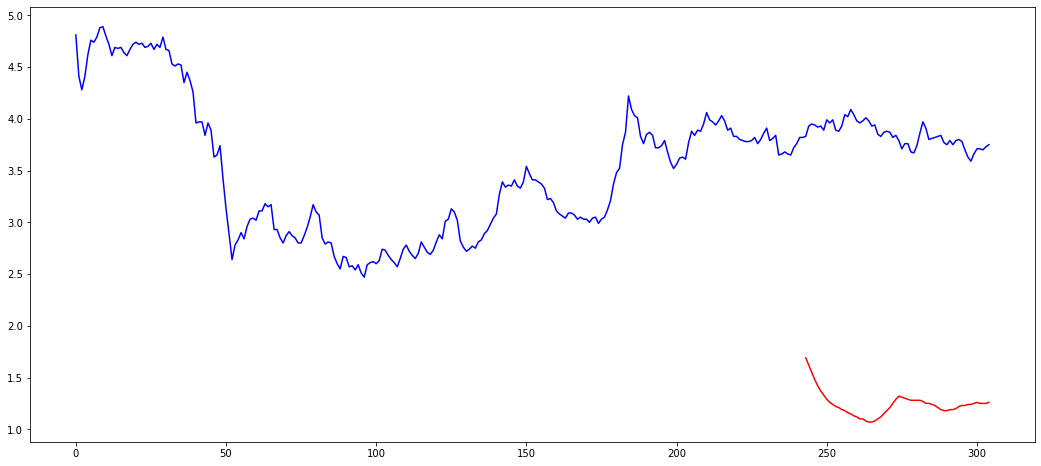

In [247]:
mtype = 'bi'
f11, r1, r2 = model_LSTM(data, 90, 200, model_type =mtype)
results[11] = ['lstm', 90, mtype, 'f11', r1, r2]
# results[11] = ['lstm', 90, mtype, 'f11', 'na', 'na']

### Weekly basis

Next 14 values:  [3.69, 3.58, 3.55, 3.46, 3.4, 3.31, 3.23, 3.14, 3.04, 2.94, 2.83, 2.72, 2.61, 2.5]
Test Scores: MSE 0.7699999809265137, MAP: 0.7099999785423279


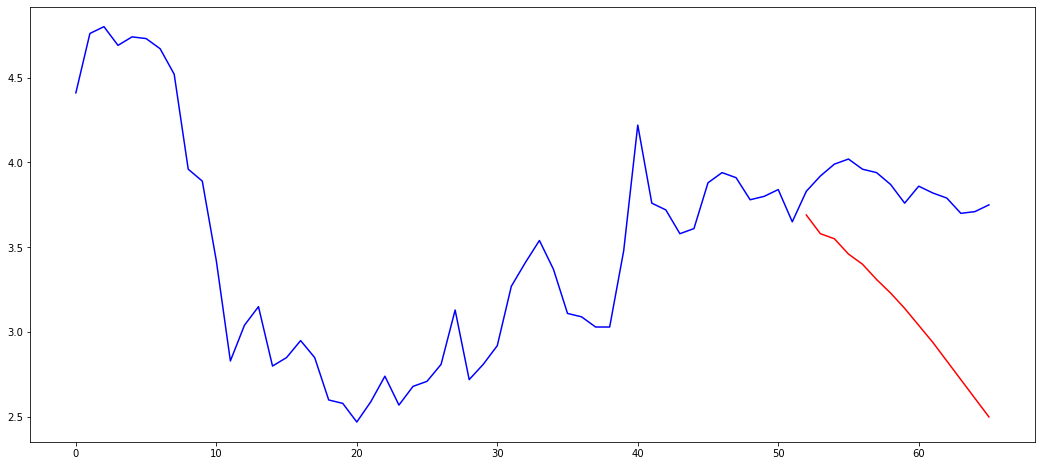

In [248]:
mtype = 'standard'
w0, r1, r2 = model_LSTM(dataW, 2, 200)
results_W[0] = ['lstm', 2, 'standard', 'w0', r1, r2]

Next 14 values:  [3.72, 3.61, 3.63, 3.56, 3.55, 3.5, 3.48, 3.44, 3.42, 3.39, 3.36, 3.34, 3.31, 3.29]
Test Scores: MSE 0.38999998569488525, MAP: 0.3799999952316284


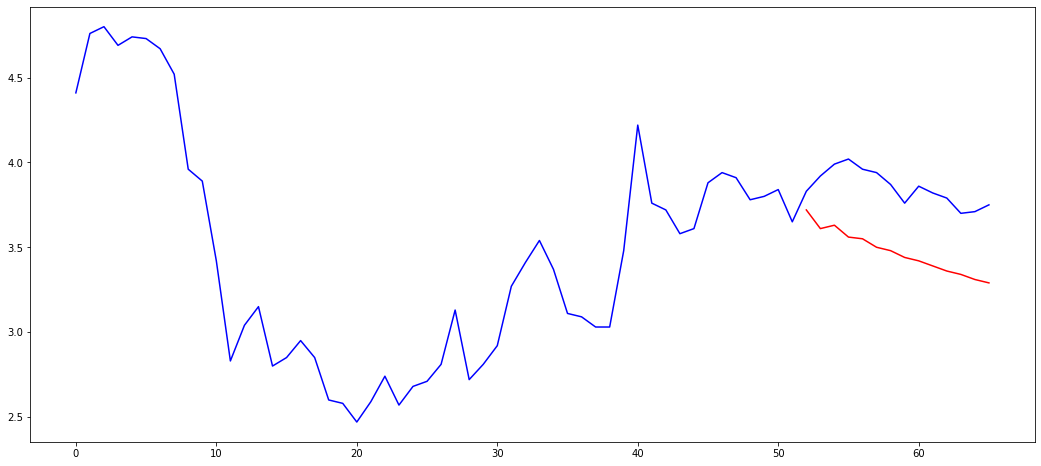

In [249]:
mtype = 'seq'
w1, r1, r2 = model_LSTM(dataW, 2, 200, model_type ='seq')
results_W[1] = ['lstm', 2, 'seq', 'w1', r1, r2]

Next 14 values:  [3.67, 3.58, 3.54, 3.47, 3.41, 3.34, 3.27, 3.2, 3.13, 3.06, 2.99, 2.92, 2.85, 2.78]
Test Scores: MSE 0.6600000262260437, MAP: 0.6200000047683716


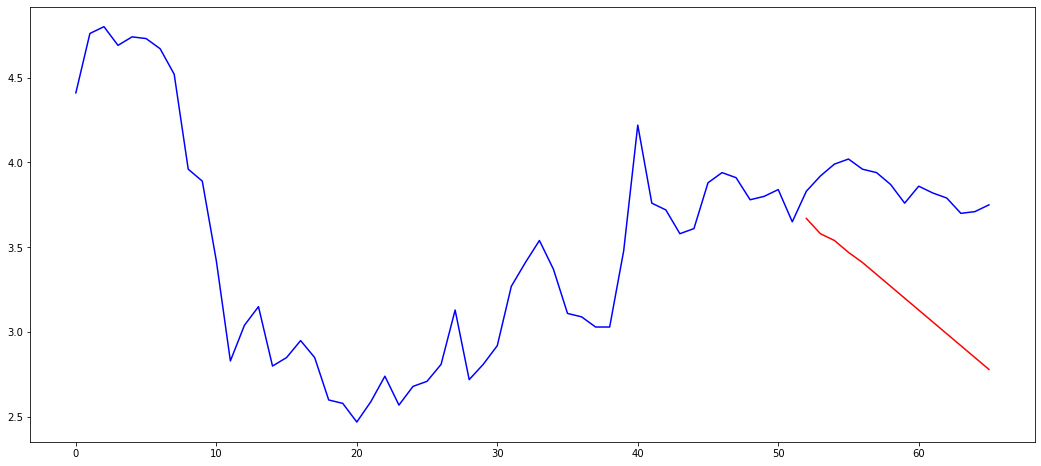

In [250]:
mtype = 'bi'
w2, r1, r2 = model_LSTM(dataW, 2, 200, model_type ='bi')
results_W[2] = ['lstm', 2, 'bi', 'w2', r1, r2]

Next 14 values:  [3.69, 3.66, 3.62, 3.62, 3.6, 3.59, 3.58, 3.57, 3.57, 3.56, 3.56, 3.56, 3.55, 3.55]
Test Scores: MSE 0.27000001072883606, MAP: 0.25999999046325684


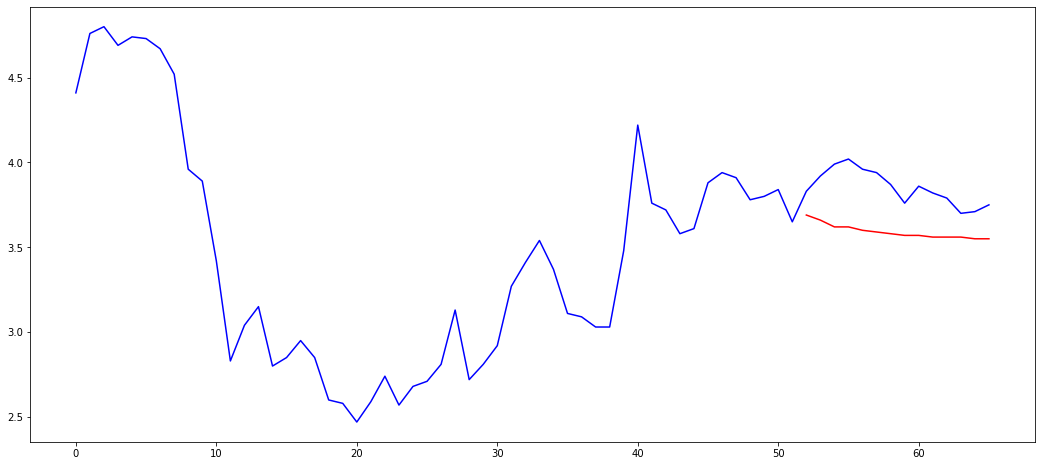

In [251]:
mtype = 'standard'
w3, r1, r2 = model_LSTM(dataW, 6, 200)
results_W[3] = ['lstm', 6, 'standard', 'w3', r1, r2]

Next 14 values:  [3.7, 3.64, 3.64, 3.61, 3.6, 3.59, 3.58, 3.57, 3.57, 3.56, 3.56, 3.55, 3.55, 3.55]
Test Scores: MSE 0.27000001072883606, MAP: 0.25999999046325684


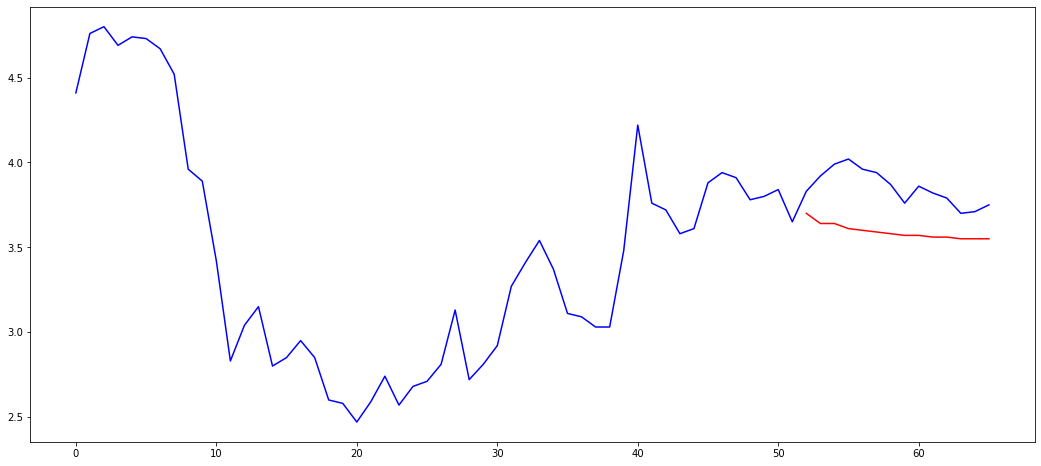

In [252]:
mtype = 'seq'
w4, r1, r2 = model_LSTM(dataW, 6, 200, model_type ='seq')
results_W[4] = ['lstm', 6, 'seq', 'w4', r1, r2]

Next 14 values:  [3.72, 3.72, 3.73, 3.73, 3.74, 3.77, 3.78, 3.8, 3.82, 3.83, 3.85, 3.86, 3.87, 3.88]
Test Scores: MSE 0.1599999964237213, MAP: 0.14000000059604645


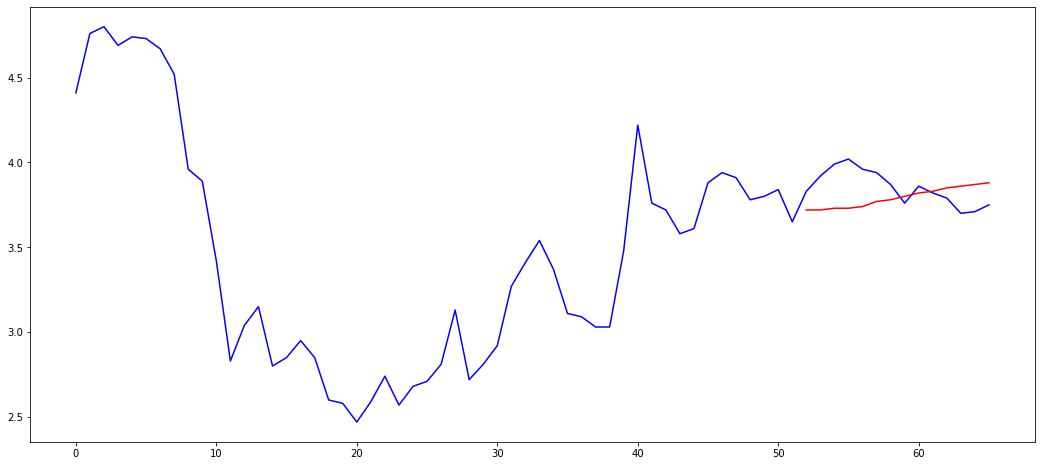

In [253]:
mtype = 'bi'
w5, r1, r2 = model_LSTM(dataW, 6, 200, model_type ='bi')
results_W[5] = ['lstm', 6, 'bi', 'w5', r1, r2]

### Monthly basis

Next 3 values:  [3.69, 3.54, 3.37]
Test Scores: MSE 0.33000001311302185, MAP: 0.3199999928474426


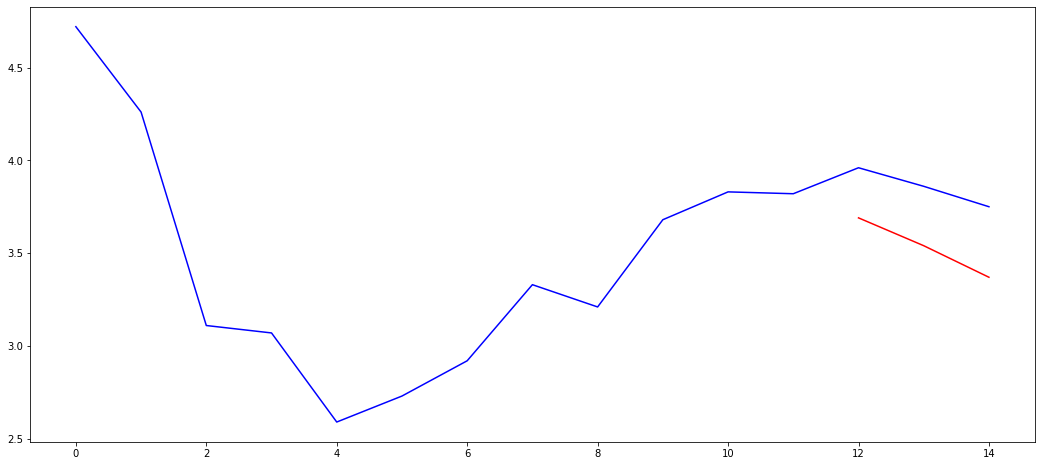

In [254]:
mtype = 'standard'
m0, r1, r2 = model_LSTM(dataM, 1, 200)
results_M[0] = ['lstm', 1, 'standard', 'm0', r1, r2]

Next 3 values:  [3.66, 3.43, 3.12]
Test Scores: MSE 0.4699999988079071, MAP: 0.44999998807907104


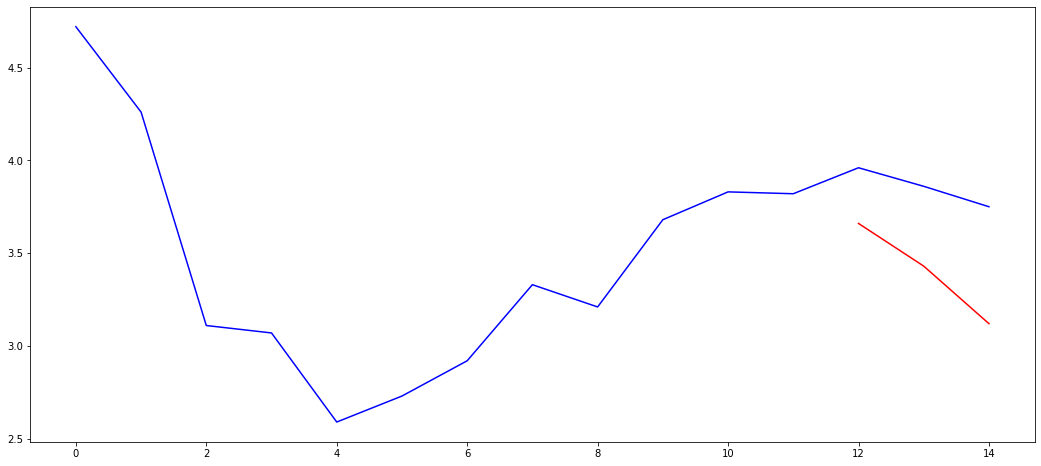

In [255]:
mtype = 'seq'
m1, r1, r2 = model_LSTM(dataM, 1, 200, model_type =mtype)
results_M[1] = ['lstm', 1, mtype,' m1', r1, r2]

Next 3 values:  [3.66, 3.48, 3.29]
Test Scores: MSE 0.38999998569488525, MAP: 0.3799999952316284


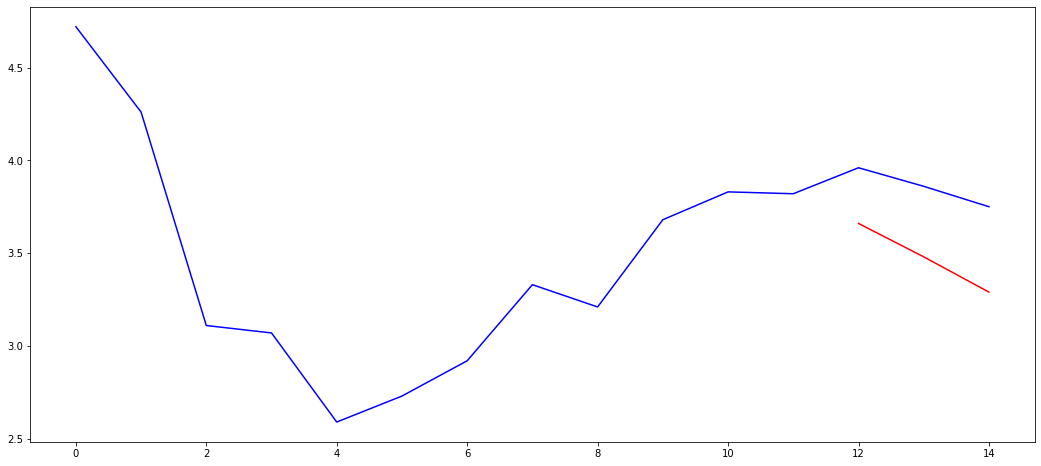

In [256]:
mtype = 'bi'
m2, r1, r2 = model_LSTM(dataM, 1, 200, model_type =mtype)
results_M[2] = ['lstm', 1, mtype, 'm2', r1, r2]

Next 3 values:  [3.8, 3.83, 3.83]
Test Scores: MSE 0.10000000149011612, MAP: 0.09000000357627869


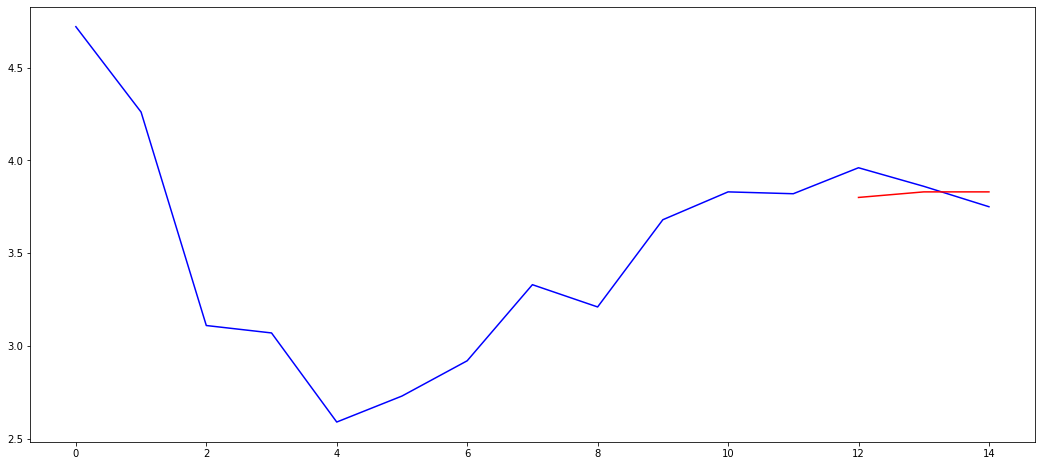

In [257]:
mtype = 'standard'
m3, r1, r2 = model_LSTM(dataM, 3, 200)
results_M[3] = ['lstm', 3, 'standard', 'm3', r1, r2]

Next 3 values:  [3.59, 3.6, 3.53]
Test Scores: MSE 0.28999999165534973, MAP: 0.2800000011920929


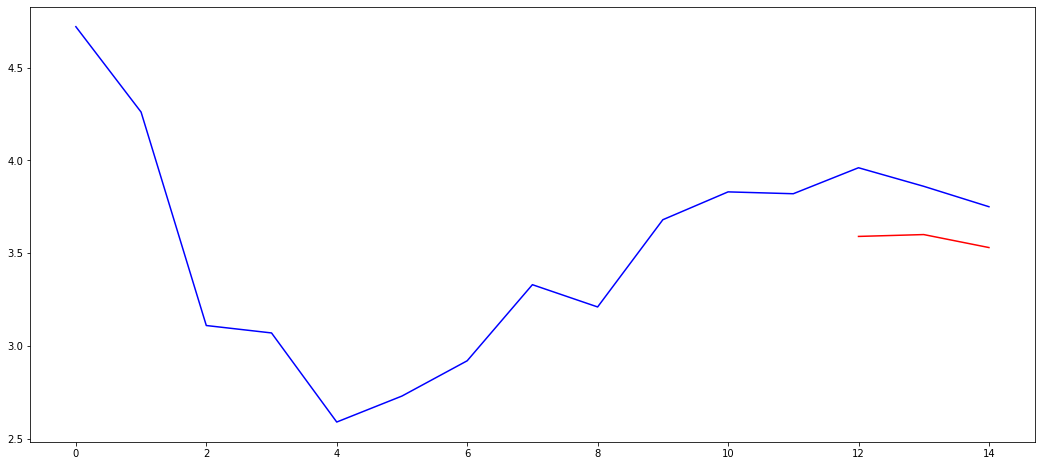

In [258]:
mtype = 'seq'
m4, r1, r2 = model_LSTM(dataM, 3, 200, model_type =mtype)
results_M[4] = ['lstm', 3, mtype, 'm4', r1, r2]

Next 3 values:  [3.95, 4.06, 4.19]
Test Scores: MSE 0.2800000011920929, MAP: 0.2199999988079071


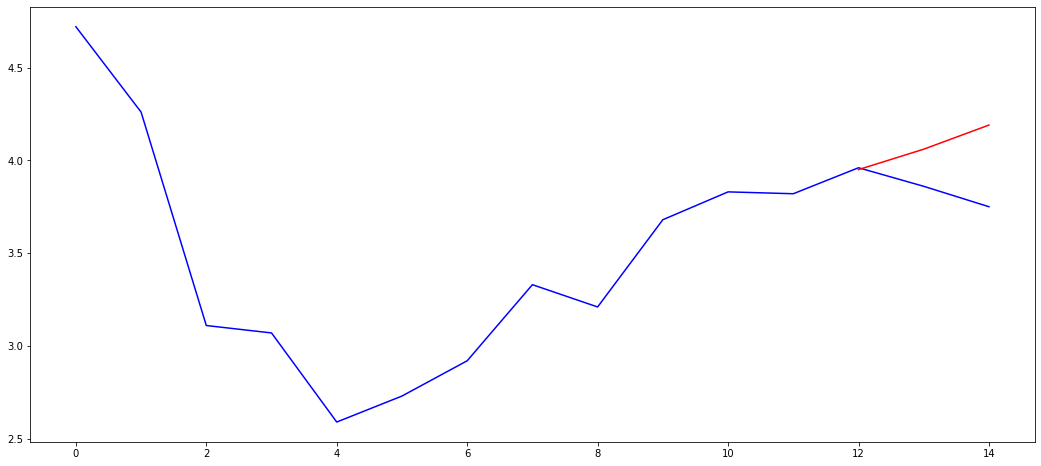

In [259]:
mtype = 'bi'
m5, r1, r2 = model_LSTM(dataM, 3, 200, model_type =mtype)
results_M[5] = ['lstm', 3, mtype, 'm5', r1, r2]

If we wanted to dive deeper we could also look at CNN LSTM, Multi-Step LSTM Models: Vector Output Model and Encoder-Decoder Models, as well as multi variable LSTM models.

## Auto-ARIMA model

In [260]:
def auto_ARIMA(dataframe):
    # split into train and test sets
    train = dataframe[dataframe.index < '2021-01-01']
    valid = dataframe[dataframe.index >= '2021-01-01']
    model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(valid))
    forecast = pd.DataFrame(forecast,columns=['Prediction'])
    forecast.index = valid.index
    #plot the predictions for validation set
    plt.plot(train, label='Train', color = 'b')
    plt.plot(valid, label='Valid', color = 'g')
    plt.plot(forecast, label='Prediction', color = 'r')
    plt.show()
    
    mse = round(np.sqrt(mean_squared_error(valid, forecast)), 2)
    mape = round(mean_absolute_error(valid, forecast), 2)
    print(f'Test Scores: MSE {mse}, MAP: {mape}')
    
    return forecast, mse, mape

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-471.312, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-460.434, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-473.345, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-472.224, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-461.963, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-471.346, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-471.346, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-469.353, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-474.986, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-472.988, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-472.987, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-473.835, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-474.956, Time=0.27 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.315 seconds


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


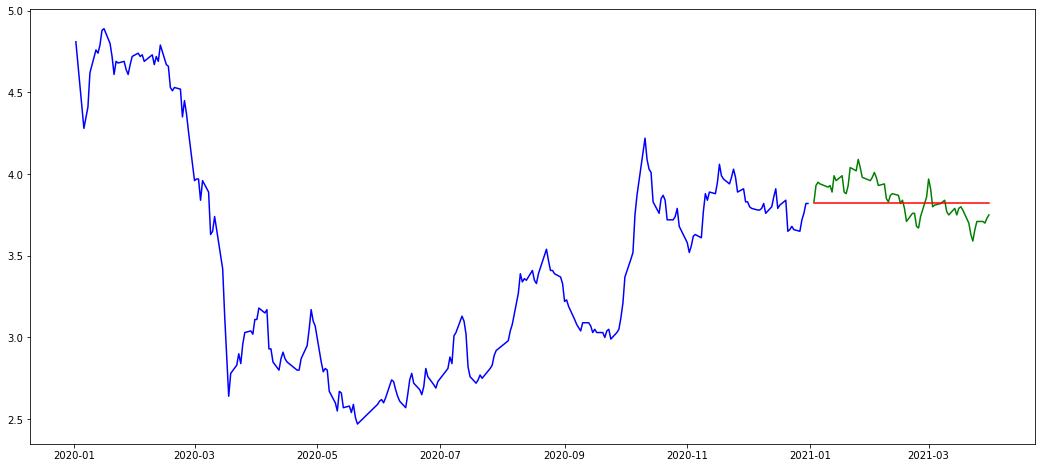

Test Scores: MSE 0.12, MAP: 0.1


In [261]:
f12, r1, r2 = auto_ARIMA(data['Price'])
results[12] = ['arima', 0, 'auto', 'f12', r1, r2]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=11.711, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=111.943, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7.819, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60.926, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=280.366, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8.684, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8.529, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9.744, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.343 seconds


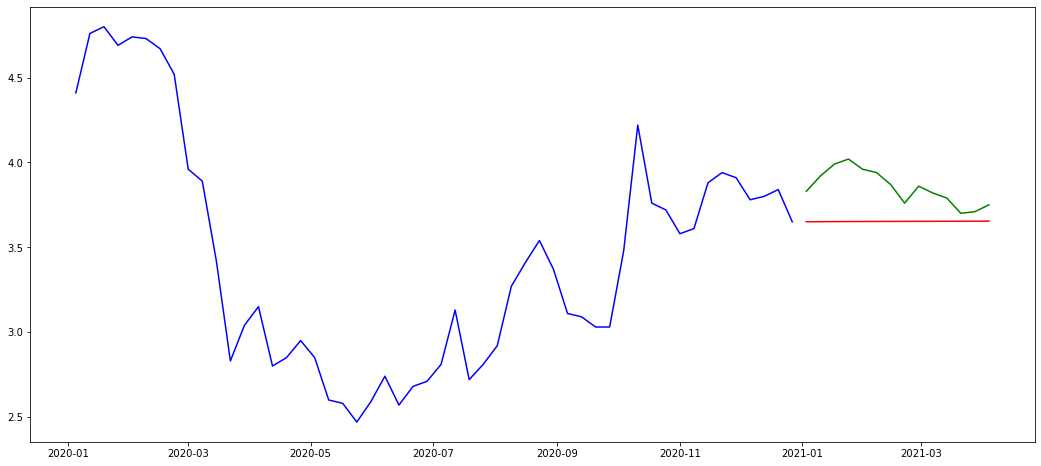

Test Scores: MSE 0.22, MAP: 0.2


In [262]:
w6, r1, r2 = auto_ARIMA(dataW['Price'])
results_W[6] = ['arima', 0, 'auto', 'w6', r1, r2]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19.992, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.212, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20.570, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22.542, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=66.072, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18.443, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21.735, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=20.710, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20.007, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=18.538, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=21.115, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 0.935 seconds


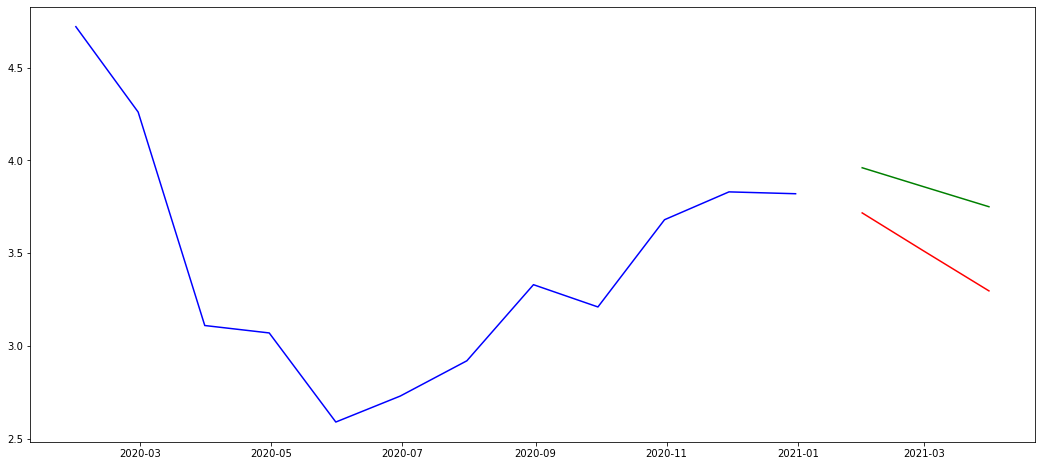

Test Scores: MSE 0.36, MAP: 0.35


In [263]:
m6, r1, r2 = auto_ARIMA(dataM['Price'])
results_M[6] = ['arima', 0, 'auto', 'm6', r1, r2]

## Prophet model

In [264]:
def model_prophet(df, frequency):
    
    # Prepare the data for Prophet
    df = df.rename(columns={'Price': 'y'})
    df = df.reset_index().rename(columns={'Date': 'ds'})
    
    # split into train and test sets
    train = df[df['ds'] < '2021-01-01']
    test = df[df['ds'] >= '2021-01-01']
    

    # Create a Prophet model and fit it to the data
    model = Prophet()
    model.fit(train)

    # Make predictions for the next 365 days
    future = model.make_future_dataframe(periods=len(test), freq=frequency)
    forecast = model.predict(future)
    
    forecast['ds'] = test['ds']
    
    # Plot the forecast
#     model.plot(forecast)
    #plot the predictions for validation set
    plt.plot(df['y'])
    plt.plot(forecast[forecast['ds'] >= '2021-01-01']['yhat'])
    plt.show()
    
    mse = round(np.sqrt(mean_squared_error(test['y'], forecast[forecast['ds'] >= '2021-01-01']['yhat'])), 2)
    mape = round(mean_absolute_error(test['y'], forecast[forecast['ds'] >= '2021-01-01']['yhat']), 2)
    print(f'Test Scores: MSE {mse}, MAP: {mape}')
    
    forecast = forecast[forecast['ds'] >= '2021-01-01']
    #results = results['yhat']
    forecast = forecast.set_index('ds')
    forecast.index.name = None
    forecast = forecast[['yhat']]
    forecast = forecast.rename(columns={"yhat": "Prediction"})
    
    return forecast, mse, mape

13:22:22 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing


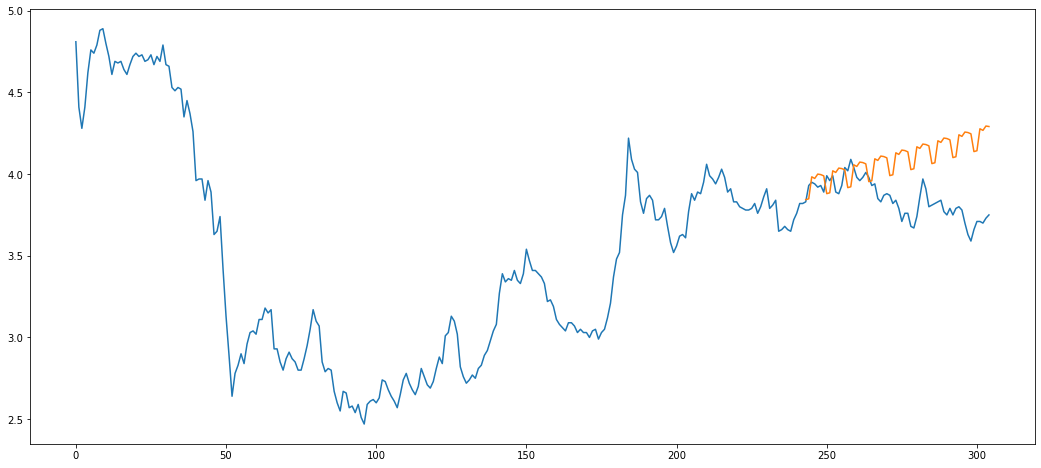

Test Scores: MSE 0.32, MAP: 0.26


In [265]:
f13, r1, r2 = model_prophet(data, 'D')
results[13] = ['prophet', 0, 'na', 'f13', r1, r2]

13:22:22 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing


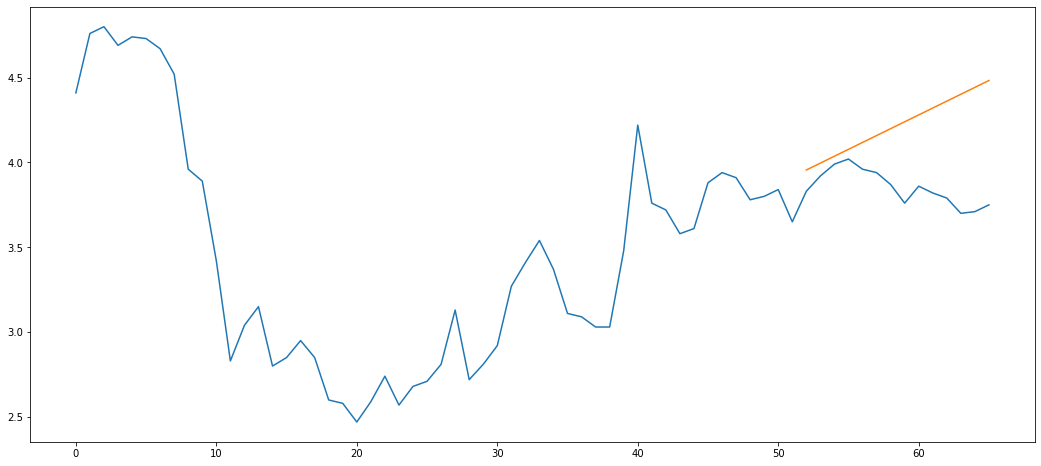

Test Scores: MSE 0.44, MAP: 0.37


In [266]:
w7, r1, r2 = model_prophet(dataW, 'W')
results_W[7] = ['prophet', 0, 'na', 'w7', r1, r2]

13:22:23 - cmdstanpy - INFO - Chain [1] start processing
13:22:23 - cmdstanpy - INFO - Chain [1] done processing


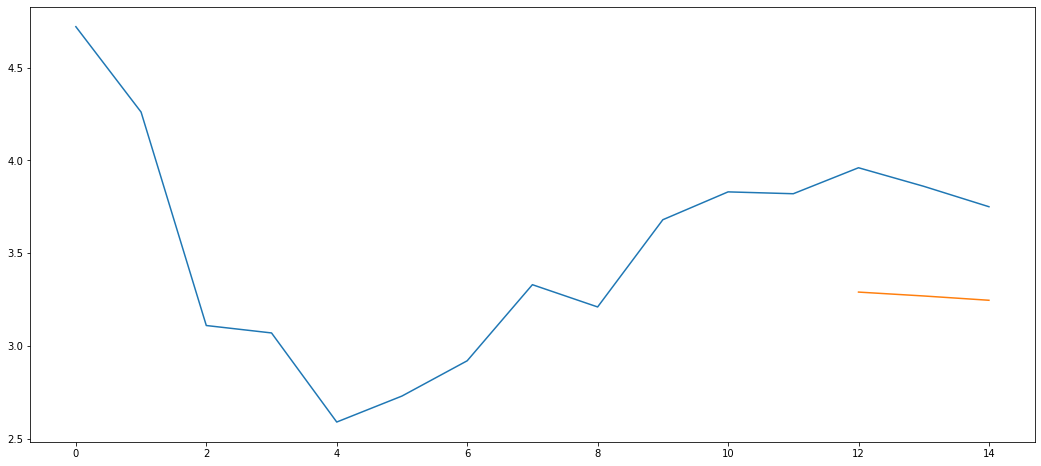

Test Scores: MSE 0.59, MAP: 0.59


In [267]:
m7, r1, r2 = model_prophet(dataM, 'M')
results_M[7] = ['prophet', 0, 'na', 'm7', r1, r2]

# 5 - Recommendations

In [268]:
cols_results = ['model', 'lookback', 'type', 'result', 'mse','map']
df_results2 = pd.DataFrame.from_dict(results, orient='index', columns = cols_results)
df_results_W2 = pd.DataFrame.from_dict(results_W, orient='index', columns = cols_results)
df_results_M2 = pd.DataFrame.from_dict(results_M, orient='index', columns = cols_results)

In [269]:
# print(df_results0)
print(df_results2)

      model  lookback      type result        mse        map
20   mov_av        30        na    f20   0.130000   0.110000
21   mov_av        60        na    f21   0.120000   0.100000
22   mov_av        90        na    f22   0.200000   0.150000
23  mov_exp        90         1    f23   0.120000   0.100000
24  mov_exp        90         2    f24   0.140000   0.120000
25  mov_exp        90         3    f25   0.120000   0.100000
0      lstm        10  standard     f0   0.410000   0.390000
1      lstm        10       seq     f1   0.130000   0.110000
2      lstm        10        bi     f2   0.400000   0.380000
3      lstm        30  standard     f3   3.150000   2.440000
4      lstm        30       seq     f4   0.140000   0.120000
5      lstm        30        bi     f5   0.240000   0.200000
6      lstm        60  standard     f6   0.160000   0.130000
7      lstm        60       seq     f7   0.130000   0.110000
8      lstm        60        bi     f8  23.219999  13.200000
9      lstm        90  s

In [270]:
# print(df_results_W0)
print(df_results_W2)

      model  lookback      type result   mse   map
20   mov_av         2        na    w20  0.12  0.10
21   mov_av         6        na    w21  0.14  0.11
22  mov_exp        90         1    w22  0.12  0.10
23  mov_exp        90         2    w23  0.14  0.12
24  mov_exp        90         3    w24  0.12  0.10
0      lstm         2  standard     w0  0.77  0.71
1      lstm         2       seq     w1  0.39  0.38
2      lstm         2        bi     w2  0.66  0.62
3      lstm         6  standard     w3  0.27  0.26
4      lstm         6       seq     w4  0.27  0.26
5      lstm         6        bi     w5  0.16  0.14
6     arima         0      auto     w6  0.22  0.20
7   prophet         0        na     w7  0.44  0.37


In [271]:
# print(df_results_M0)
print(df_results_M2)

      model  lookback      type result   mse   map
20   mov_av         1        na    m20  0.12  0.10
21   mov_av         3        na    m21  0.12  0.10
22  mov_exp        90         1    m22  0.12  0.10
23  mov_exp        90         2    m23  0.14  0.12
24  mov_exp        90         3    m24  0.12  0.10
0      lstm         1  standard     m0  0.33  0.32
1      lstm         1       seq     m1  0.47  0.45
2      lstm         1        bi     m2  0.39  0.38
3      lstm         3  standard     m3  0.10  0.09
4      lstm         3       seq     m4  0.29  0.28
5      lstm         3        bi     m5  0.28  0.22
6     arima         0      auto     m6  0.36  0.35
7   prophet         0        na     m7  0.59  0.59


## Results

### Sheet 0
#### DAILY: 
We will discount auto-ARIMA and exponential smoothing results as they are just a flat line.
The best daily forecasting models for data sheet 0 in MSE are:
moving average look back 30, sequential LSTM with lookback 30, and standard LSTM with lookback 20 
and in MAP are:
the same

#### WEEKLY:
The best weekly forecasting models for data sheet 0 in MSE are: moving average with lookback 6, exponential smoothing with smoothing .5 , and moving average with lookback 2 
and in MAP are: the same

#### MONTHLY:
The best monthly forecasting models for data sheet 0 in MSE are: sequential LSTM with lookback 3 , bidirectional LSTM with lookback 3 , and moving average with lookback 3 
and in MAP are: the same

### Sheet 1
#### DAILY: 
We will discount exponential smoothing and autoarima results as they are just a flat line.

The best daily forecasting models for data sheet 1 in MSE are:
prophet, moving average lookback 30 and standard lstm lookback 10
and in MAP are: prophet, standard lstm lookback 10 and moving average lookback 30


#### WEEKLY:
We will discount exponential smoothing results as they are just a flat line.

The best weekly forecasting models for data sheet 1 in MSE are: moving average lookback 2, bidirectional lstm lookback 2 and standard lstm lookback 2.
and in MAP are: the same

#### MONTHLY:
We will discount moving average 1 and exponential smoothing results as they are just a flat line.

The best monthly forecasting models for data sheet 1 in MSE are: standard LSTM lookback 3, moving average lookack 3 and bidirectional lstm lookback 3
and in MAP are: the same

### Sheet 2
#### DAILY: 
We will discount exponential smoothing and auto-ARIMA results as they are just a flat line.
The best daily forecasting models for data sheet 2 in MSE are: moving average lookback 60, sequential LSTM lookback 10, and sequential LSTM lookback 60
and for MAP are: the same


#### WEEKLY:
We will discount moving average lookback 2 and exponential smoothing results as they are just a flat line.
The best weekly forecasting models for data sheet 2 in MSE are: moving average lookback 6, bidirectional LSTM lookback 6 and auto arima.
and in MAP are: the same

#### MONTHLY:
We will discount moving average lookback 1 and exponential smoothing results as they are just a flat line.
The best monthly forecasting models for data sheet 2 in MSE are: standard LSTM lookback 3, moving average lookback 3, and bidirectional lstm lookack 3
and for MAP are: the same

Based on these results we will use sequential LSTM lookback 30 for dialy forecasts, moving average with lookback 6 for weekly and standard LSTM with lookack 3 for monthly

# 5 - Investment

Next 61 values:  [273.74, 272.88, 265.72, 262.99, 262.62, 257.24, 256.94, 248.53, 252.41, 252.82, 252.54, 252.71, 250.75, 248.25, 247.3, 244.37, 238.33, 233.51, 230.21, 232.16, 233.04, 236.05, 236.85, 236.0, 235.28, 234.7, 231.97, 226.99, 222.56, 219.65, 211.19, 209.54, 207.98, 207.84, 210.71, 215.92, 215.16, 216.18, 214.74, 212.98, 209.78, 203.43, 196.65, 191.14, 190.56, 194.63, 199.39, 201.42, 202.77, 201.64, 200.29, 197.33, 194.2, 189.35, 182.86, 179.68, 188.28, 187.51, 176.99, 183.65, 189.76]
Test Scores: MSE 62.970001220703125, MAP: 54.97999954223633


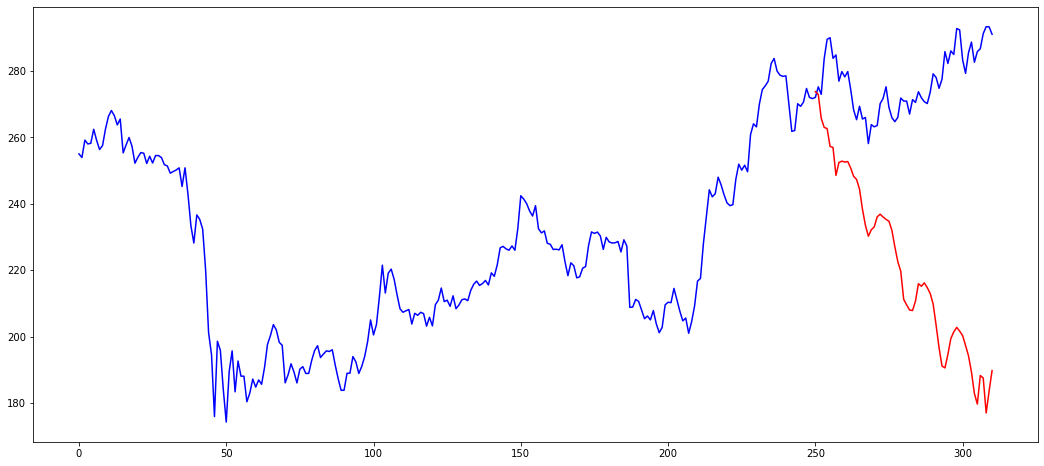

Next 63 values:  [21.12, 20.87, 20.77, 20.73, 20.79, 20.82, 21.02, 21.51, 21.92, 22.27, 22.55, 22.76, 23.06, 23.49, 24.4, 21.88, 22.9, 20.97, 20.72, 20.19, 20.43, 19.88, 20.72, 21.01, 21.22, 21.97, 22.53, 23.19, 23.91, 24.58, 24.81, 25.36, 22.57, 22.37, 22.76, 23.9, 25.39, 26.23, 25.91, 24.37, 23.46, 25.24, 24.09, 25.59, 25.89, 26.52, 26.22, 26.2, 27.57, 29.07, 29.4, 30.47, 27.54, 26.11, 25.99, 26.66, 27.35, 29.16, 30.54, 33.9, 29.95, 27.55, 27.26]
Test Scores: MSE 4.050000190734863, MAP: 2.609999895095825


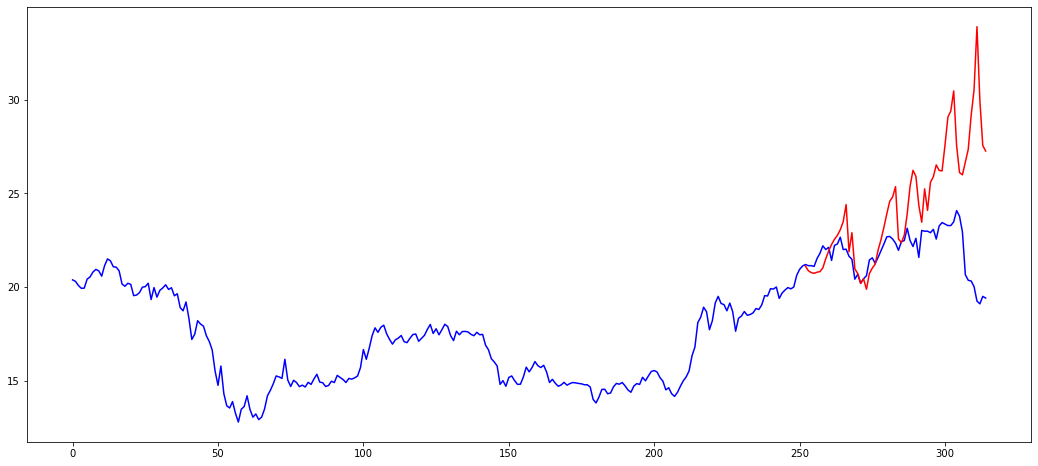

Next 62 values:  [3.87, 3.91, 3.95, 4.0, 4.04, 4.08, 4.12, 4.16, 4.2, 4.24, 4.28, 4.31, 4.34, 4.37, 4.4, 4.43, 4.45, 4.47, 4.49, 4.51, 4.53, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6, 4.61, 4.62, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.62, 4.61, 4.6, 4.59, 4.58, 4.57, 4.56, 4.55, 4.54, 4.53, 4.51, 4.49, 4.47, 4.45, 4.43, 4.41, 4.39, 4.36, 4.33, 4.3, 4.27]
Test Scores: MSE 0.6499999761581421, MAP: 0.6000000238418579


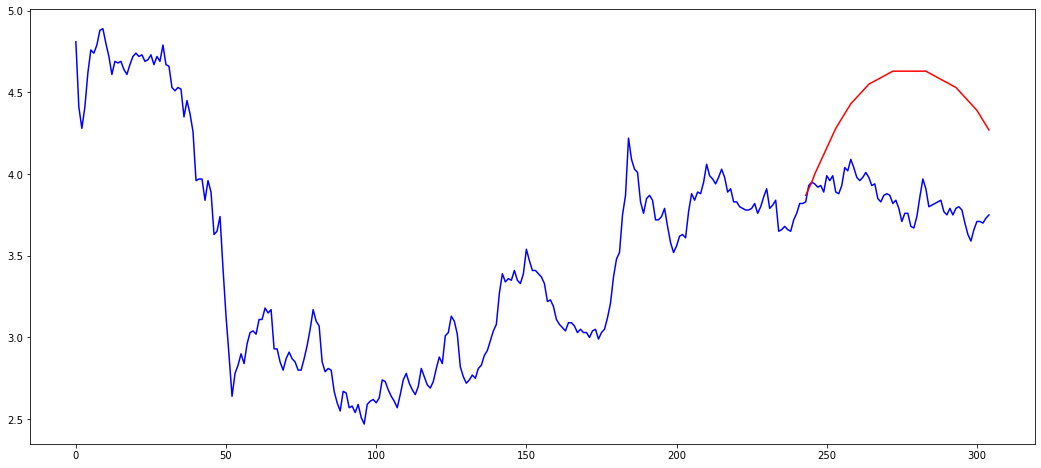

In [276]:
forecastD0, _, _ = model_LSTM(data0, 30, 200, 'seq')
forecastD1, _, _ = model_LSTM(data1, 30, 200, 'seq')
forecastD2, _, _ = model_LSTM(data2, 30, 200, 'seq')

Next 14 values:  [264.25666666666666, 268.3961111111111, 271.19712962962967, 271.39665123456797, 269.3410931069959, 269.20460862482855, 268.96537672896665, 269.75016173935, 269.97583684405646, 269.7722880464609, 269.5015608484431, 269.5283054720176, 269.5822549465491, 269.6850679828129]
Test Scores: MSE 11.79, MAP: 9.37


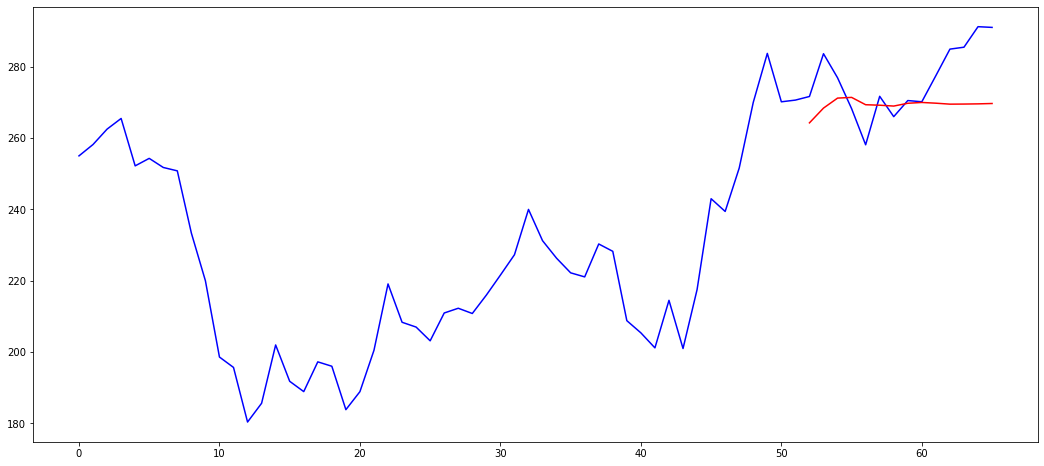

Next 14 values:  [19.27, 19.231666666666666, 19.32361111111111, 19.462546296296296, 19.53130401234568, 19.453188014403292, 19.37871935013717, 19.396839241826704, 19.424368004353372, 19.441160819893753, 19.437596573826664, 19.421978667406826, 19.41677710957408, 19.423120069480238]
Test Scores: MSE 2.52, MAP: 2.21


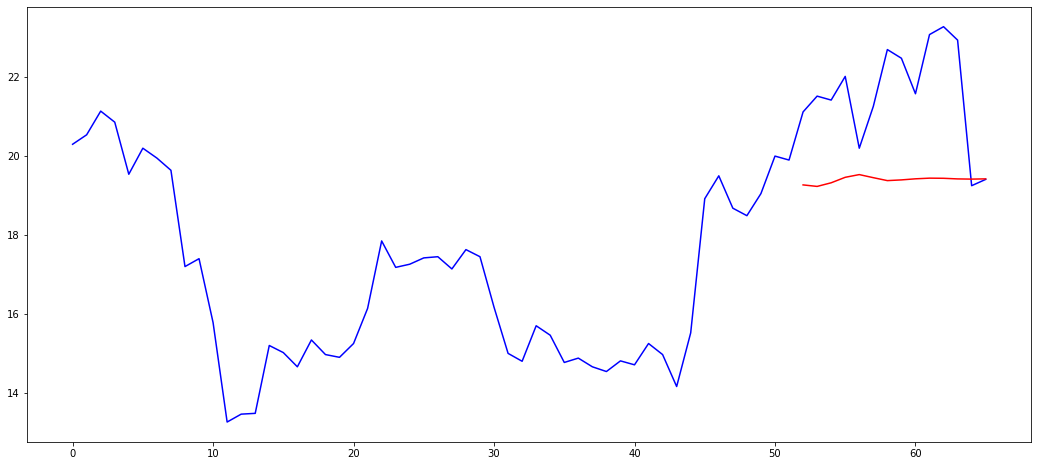

Next 14 values:  [3.82, 3.7999999999999994, 3.7816666666666667, 3.7819444444444446, 3.778935185185185, 3.7687577160493824, 3.78855066872428, 3.7833091135116597, 3.7805272990969363, 3.780337404501981, 3.780069564511571, 3.780258627732635, 3.7821754463465105, 3.7811129092835487]
Test Scores: MSE 0.12, MAP: 0.1


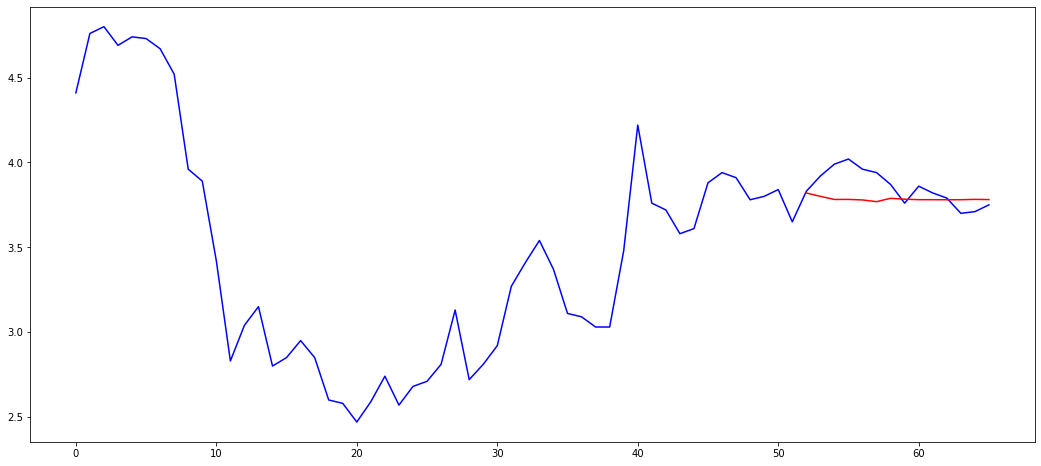

In [277]:
forecastW0, _, _ = moving_av(dataW0, 6)
forecastW1, _, _ = moving_av(dataW1, 6)
forecastW2, _, _ = moving_av(dataW2, 6)

Next 3 values:  [275.04, 273.28, 278.3]
Test Scores: MSE 12.359999656677246, MAP: 10.920000076293945


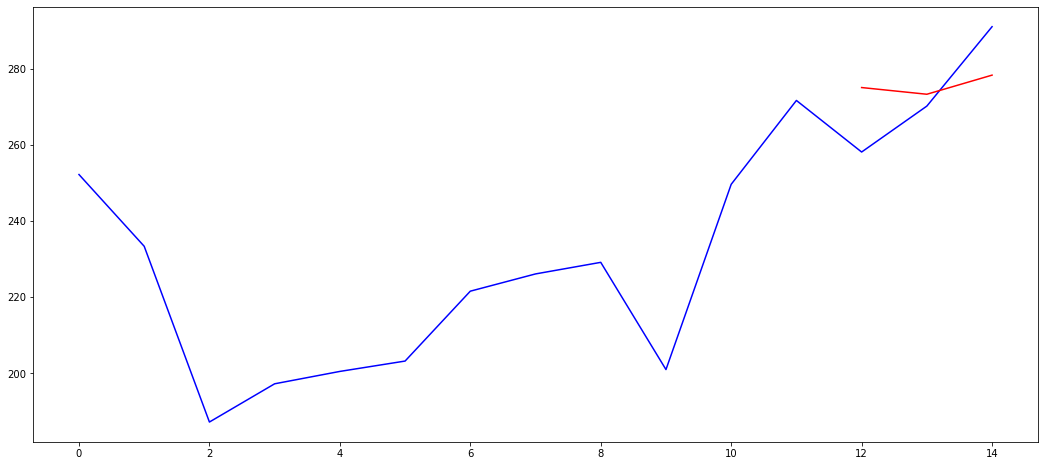

Next 3 values:  [19.8, 19.9, 19.95]
Test Scores: MSE 1.0399999618530273, MAP: 0.8700000047683716


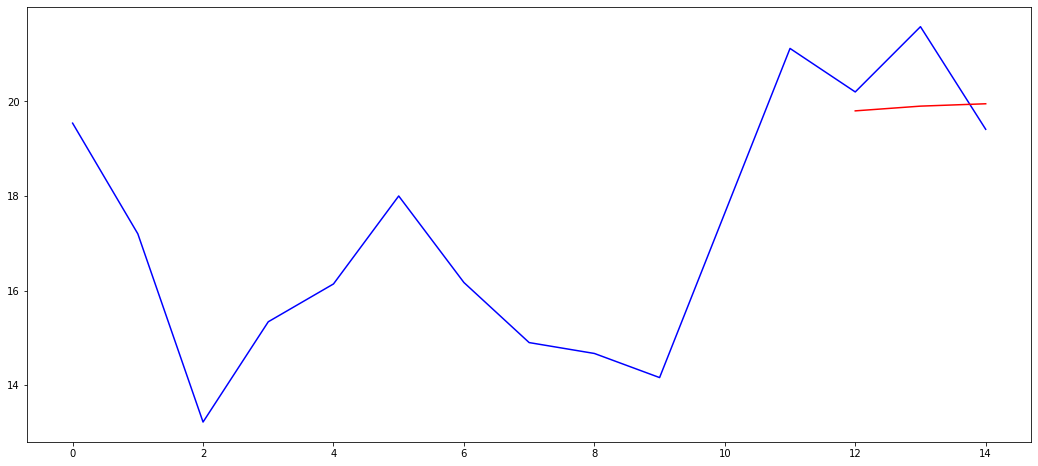

Next 3 values:  [3.74, 3.78, 3.75]
Test Scores: MSE 0.14000000059604645, MAP: 0.10000000149011612


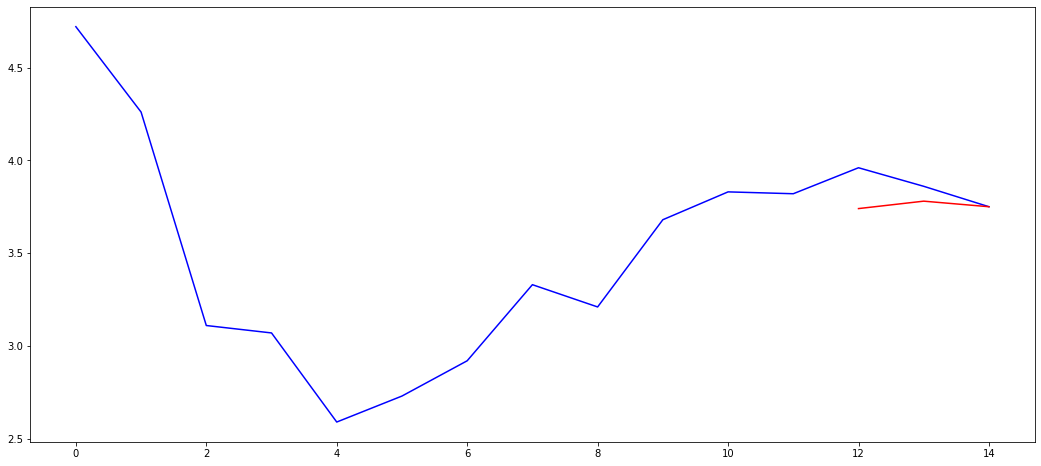

In [278]:
forecastM0, _, _ = model_LSTM(dataM0, 3, 200)
forecastM1, _, _ = model_LSTM(dataM1, 3, 200)
forecastM2, _, _ = model_LSTM(dataM2, 3, 200)

In [286]:
investmentsD = {}
investmentsW = {}
investmentsM = {}

In [365]:
data_invest = dataM2
forecast_data = forecastM2

In [366]:
def BB(df):
    # Assuming your DataFrame is named 'df' and 'Prediction' is the column of interest
    window = 20  # Bollinger Bands window size
    std_dev = 2  # Standard deviation for the bands

    # Calculate the rolling mean and standard deviation
    rolling_mean = df['Prediction'].rolling(window=window).mean()
    rolling_std = df['Prediction'].rolling(window=window).std()

    # Calculate the upper and lower bands
    upper_band = rolling_mean + std_dev * rolling_std
    lower_band = rolling_mean - std_dev * rolling_std
    
    df['Upper'] = upper_band
    df['Lower'] = lower_band

    # Plot the Bollinger Bands
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['actual'], label='Price')
    plt.plot(df.index, rolling_mean, label='Rolling Mean')
    plt.plot(df.index, upper_band, label='Upper Band')
    plt.plot(df.index, lower_band, label='Lower Band')
    plt.fill_between(df.index, lower_band, upper_band, alpha=0.2)  # Fill area between the bands
    plt.legend()
    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Prediction')
    plt.axvline(x='2021-01-01', color='black', linestyle='dashed')
    plt.show()
    
    return df

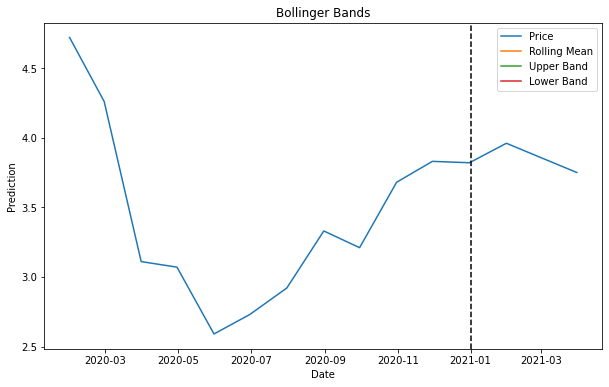

In [367]:
a = data_invest[data_invest.index < '2021-01-01']['Price']
b = forecast_data['Prediction']
c = pd.concat([a,b])
predictions = c.to_frame().rename(columns={0: 'Prediction'})
predictions['actual'] = data_invest['Price']
newdf = BB(predictions)

In [368]:
newdf = newdf[newdf.index >= '2021-01-01']
newdf['higher'] = newdf['actual'] > newdf['Upper']
higher = newdf[newdf['higher']]
newdf['lower'] = newdf['actual'] < newdf['Lower']
lower = newdf[newdf['lower']]

<ipython-input-368-554a5a422895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['higher'] = newdf['actual'] > newdf['Upper']
<ipython-input-368-554a5a422895>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['lower'] = newdf['actual'] < newdf['Lower']


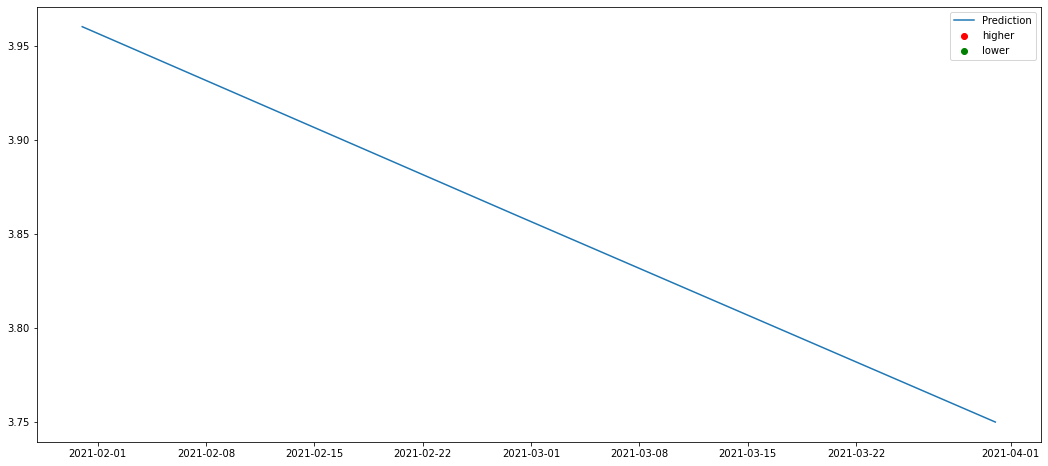

In [369]:
plt.plot(newdf.index, newdf['actual'], label='Prediction')
plt.scatter(higher.index, higher['actual'], label='higher', color = 'r')
plt.scatter(lower.index, lower['actual'], label='lower', color = 'g')
plt.legend()

In [370]:
newdf

,Prediction,actual,Upper,Lower,higher,lower
Date,,,,,,
2021-01-31,3.74,3.96,NaN,NaN,False,False
2021-02-28,3.78,3.86,NaN,NaN,False,False
2021-03-31,3.75,3.75,NaN,NaN,False,False


In [371]:
def invest(df, original):
    #start by 'buying' one stock at the end of the year to calculate proft
    december = original[original.index < '2021-01-01'].iloc[-1]
    print(december)
    investment = float(december['Price'])
    stock = 1
    money = 0
    print(investment)
    #iterate through the dataframe where the points that are below of above bollinger bands are stored
    for index,row in df.iterrows():
        if row['higher']:
            #sell action: sell all stocks at market value
            if stock > 0:
                print('sell')
                share = row['actual']
                print(share)
                money += (stock*share)
                stock = 0
                print(money, stock)
        elif row['lower']:
            print('buy')
            #buy action: buy one stock at marker value
            share = row['actual']
            print(share)
            money -= share
            stock +=1
            print(money, stock)
    if df.iloc[-1]['higher']:
        pass
    else:
        #sell all stock at the end at market value
        if stock > 0:
            print('final sell')
            share = row['actual']
            print(share)
            money += (stock*share)
            stock = 0
            print(money, stock)
    
    #calculate profit
    profit = money - investment
    print(profit)
    increase = (profit/investment)*100
    return increase

increase = invest(newdf, data_invest)
print(increase)

Price       3.82
Open        3.82
High        3.85
Low         3.77
Vol.        1.65
Change %    0.00
Name: 2020-12-31 00:00:00, dtype: float64
3.82
final sell
3.75
3.75 0
-0.06999999999999984
-1.8324607329842892


In [372]:
# investmentsD['sheet 0'] = increase
# investmentsD['sheet 1'] = increase
# investmentsD['sheet 2'] = increase
# investmentsW['sheet 0'] = increase
# investmentsW['sheet 1'] = increase
# investmentsW['sheet 2'] = increase
# investmentsM['sheet 0'] = increase
# investmentsM['sheet 1'] = increase
investmentsM['sheet 2'] = increase

In [373]:
#in percentage increase
investmentsD

{'sheet 0': 6.567274065893626,
 'sheet 1': -13.920454545454517,
 'sheet 2': -38.219895287957755}

In [374]:
investmentsW

{'sheet 0': 7.604197457877639,
 'sheet 1': 6.130653266331671,
 'sheet 2': 2.739726027397263}

In [375]:
investmentsM

{'sheet 0': 7.130498803607585,
 'sheet 1': -8.096590909090914,
 'sheet 2': -1.8324607329842892}

Results show that the investment strategy is not particularly strong. It would be better to use models that work best for each data set rather than pick a general model for all datasets.